# Hyperparameter estimation for logistic normal prior distribution

In [1]:
import os
import pysam
import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from genepeeks.common import utilities as util
import seaborn as sns
# to clean up later -- temporary fix
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from cnv import utilities as DMD_util
from cnv import coverage_matrix as cov
import statsmodels.formula.api as sm
import scipy.stats

%matplotlib inline

INFO:config:Using ini file set by environment: /Users/velina/Documents/GitHub/genepeeks-science/conf/genepeeks.ini
/Users/velina/.pyenv/versions/2.7.11/envs/dmd/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# workaround to force real time print output in notebooks
# see http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

## Fitting Logistic Normal Distributions

Here we use the EM algorithm presented by Huang and Malisiewicz http://people.csail.mit.edu/tomasz/papers/huang_hln_tech_report_2006.pdf (with more complete formulation by Hoff http://www.stat.washington.edu/people/pdhoff/Preprints/nhed.old.pdf) for estimating the hyperparameters of a hierarchical logistic MVN distribution.

Briefly, we assume in our model that the sequencing reads of a normal (non-carrier) individual will be distributed across $k$ exons according to a multinomial distribution with probability vector $\mathbf{p}$. Our model also assumes that for each individual, $\mathbf{p}$ is generated as follows:
$$ \mathbf{v} = \{v_1,...v_{k-1}\} \sim MVN(\mathbf{\mu}, \mathbf{\Sigma}) $$ where $\mathbf{\mu}$ is of length $k-1$ and $\mathbf{\Sigma}$ is a $k-1$ dim covariance vector. 
Set $v_k=0$ and let $$p_i = \dfrac{\exp{v_i}}{\sum_{i=1}^k \exp {v_i}}$$
Note that we can hold $v_k = 0$ and limit this distribution to the $k-1$ simplex without loss of specificity, because of the softmax normalization step. (This also makes intuitive sense since the $k$ components of $\mathbf{p}$ must sum to 1, so $p_k$ can be fully determined from the other vector components.)

Since we don't know the $\mathbf{v}$ for our subjects, we can try to infer the maximum likelihood estimates of $\mathbf{\mu}$ and $\mathbf{\Sigma}$ using an expectation maximization algorithm, where we alternate estimating the true values of $\mathbf{v_1}, ... \mathbf{v_N}$ for $N$ subjects total and iteratively maximizing the conditional expectation of the log likelihood. This can be done fairly easily thanks to the nifty normal approximation to the conditional distribution of the $\mathbf{v}$ vectors.

In [245]:
# note that the log-likelihood here is negative since we want to maximize it
# initial reshaping and flattening at end of each function are for compatibility with scipy.optimize.fmin_cg
def loglike_vcond(z, n, edf, mu, inv_cov):
    """Calculates the negative log likelihood of z (v in our notation above) conditional on the data and current values of 
    mu and cov"""
    z = z.reshape((-1,1))
    
    neg_loglike = (-(n * np.dot(z.flatten(), edf.flatten()) - n * np.log(1 + np.sum(np.exp(z))) - 
                   0.5 *np.dot(np.dot((z - mu).T, inv_cov), (z - mu))))
    
    return neg_loglike[0][0]

# gradient of the conditional log-likelihood 
def grad_vcond(z, n, edf, mu, inv_cov):
    z = z.reshape((-1,1))
    pz = np.exp(z - np.amax(z))
    pz = pz / (np.exp(-np.amax(z)) + np.sum(pz))
 
    grad = -(n * (edf - pz) - np.dot(inv_cov,(z - mu)))
    return grad.flatten()

In [246]:
# based on matlab code from https://www.mathworks.com/matlabcentral/fileexchange/11275-hlnfit
def conditional_mode(y, mu, cov, EMiter, initialz):
    """Calculates the conditional mode of z (v above) given data for a single individual and current estimates
    of mu and cov
    y -- kx1 array of read counts in each exon for single individual (histogram of multinomial draws)
    mu -- currrent estimate of mu, k-1 x 1 array
    cov -- current estimate of cov, k-1 x k-1 array
    initialz -- initial estimate for z, k-1 x 1 array 
    
    Returns 
    mu_hat -- conditional mode of z, k-1 x 1 array
    cov_hat -- inverse of the negative hessian calculated using conditional mode mu_hat, k-1 x k-1 array
    loglike -- log-likelihood of z and data after convergence, float
    """
    max_iterations = 25 
    tol = 1e-9
    k = len(mu)+1
    initialz = initialz.reshape(-1, 1)
    z = initialz
    n = np.sum(y)
    edf = (y / float(n))[:-1].reshape(-1, 1) # must be column vector
    inv_cov = np.linalg.inv(cov)
    grad = np.zeros((k-1, 1))
    neg_hess = np.zeros((k-1, k-1))

    change = tol+1
    iters = 0
    # authors use previously implemented code for Polak-Ribiere -- instead of recreating, we use 
    # the scipy implemented version here
    args = (n, edf, mu, inv_cov)
    z = scipy.optimize.fmin_cg(loglike_vcond, z, fprime=grad_vcond, args=args, maxiter=20, disp=0).reshape((-1, 1))
    z_cg = z
    
    # Newton-raphson after coarse optimization with Polak-Ribiere
    tries = 0
    while iters < max_iterations and change > tol:
        oldz = z
        
        # note the addition of the final dimension (stays constant at 0)
        pz = np.exp(z - np.amax(z))
        pz = pz / (np.exp(-np.amax(z)) + np.sum(pz))
        
        # gradient with respect to unnormalized intensities (z vector)
        grad = n * (edf - pz) - np.dot(inv_cov, (z - mu))
        # negative hessian (second derivative)
        neg_hess = inv_cov + n * (np.diag(pz.flatten())) - n * (np.dot(pz, pz.T)) # note outer product here
        z = z + np.dot(np.linalg.inv(neg_hess), grad)
        
        change = np.amax(np.absolute(z - oldz))
        iters += 1
        
        # try reinitializing with different values if stuck
        if iters > max_iterations - 1:
            z = initialz + 2 * (np.random.rand(k-1, 1) - 0.5 * np.ones((k-1, 1)))
            iters = 0
            tries += 1
        
        # something is probably wrong if this is actually happening
        if tries > max(EMiter * 5, 20):
            logger.info('Giving up on Newton Raphson, change is {}'.format(change))
            z = z_cg  # why reset to original starting value in authors' code? shouldn't it be z_cg
            iters = max_iterations 
            
    mu_hat = z
    cov_hat = np.linalg.inv(neg_hess)
    # conditional log likelihood
    loglike = (n * np.dot(z.flatten(), edf.flatten()) - n * np.log(1 + np.sum(np.exp(z))) - 
               0.5 *np.dot(np.dot((z - mu).T, inv_cov), (z - mu)))
    
    return mu_hat, cov_hat, loglike

In [247]:
def hln_EM(Y, logger, max_iterations=25, tol=1e-6):
    """Returns estimates for mu and cov after EM on subject data.
    Y -- N x k matrix where k is the number of exons and N is the number of subjects
    logger -- logger object to pass logging to
    """
    m = Y.shape[0]
    k = Y.shape[1]
    mu = np.zeros((k-1, 1))
    cov = np.eye(k-1)
    mu_hat = np.zeros((k-1, m))
    cov_hat = np.zeros((k-1, k-1, m))
    per_doc_loglikes = np.zeros((m, 1))
    
    change = tol+1
    iters = 0
    mu_hat = np.tile(mu, [1, m])
    
    while iters < max_iterations and change > tol:
        oldmu = mu
        oldcov = cov
        
        # for each subject
        for i in range(m):
            mu_hat[:, i:i+1], cov_hat[:, :, i], per_doc_loglikes[i]= conditional_mode(Y[i, :], mu, cov, 
                                                                                      iters, mu_hat[:, i])
            
        # update based on maximization with normal approximation
        mu = (1. / m) * np.sum(mu_hat, axis=1).reshape((-1, 1))
        c_mu_hat = mu_hat - np.tile(mu, [1, m])
        cov = (1. / m) * (np.dot(c_mu_hat, c_mu_hat.T) + np.sum(cov_hat, axis=2))
        
        change = np.amax([np.amax(np.absolute(mu - oldmu)), np.amax(np.absolute(cov - oldcov))])
        iters += 1
        logger.info('iteration: {}, change: {}'.format(iters, change))
    
    return mu, cov

In [446]:
col_test = np.ones((3,1))
tile_test = np.tile(col_test, [1, 5])
np.dot(tile_test, tile_test.T)

array([[ 5.,  5.,  5.],
       [ 5.,  5.,  5.],
       [ 5.,  5.,  5.]])

In [248]:
def gen_hln_samples(numdocs, numdraws, mu, cov):
    """Generate probability vectors for multinomial distributions from hierarchical logistic normal model"""
    X = np.exp(np.random.multivariate_normal(mu, cov, numdocs))
    X = np.concatenate((X, np.ones((numdocs, 1))), axis=1)
    X = X / X.sum(axis=1)[:, None]  # add the extra dimension so matrix division returns properly
    
    Y = np.zeros((numdocs, len(mu)+1))
    for i in range(len(X)):
        Y[i] = np.random.multinomial(numdraws, X[i])
    
    return Y, X

## Comparing results to authors' code 
We can run the authors' code (with some modifications and additions) in Octave to make sure we have fully replicated their results. 

In [249]:
import scipy.io as sio
# load small data vector generated in Octave -- contains data Y, and estimates for mu and cov generated from authors 
# EM code
mat_results = sio.loadmat('hln_test.mat')
mat_results

{'Y': array([[ 305.,  507.,  188.],
        [ 297.,  482.,  221.],
        [ 259.,  551.,  190.],
        [ 299.,  512.,  189.],
        [ 312.,  505.,  183.],
        [ 310.,  481.,  209.],
        [ 272.,  491.,  237.],
        [ 277.,  484.,  239.],
        [ 277.,  544.,  179.],
        [ 320.,  460.,  220.]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, written by Octave 4.0.3, 2017-03-21 15:07:13 UTC',
 '__version__': '1.0',
 'cov2': array([[ 0.00833967,  0.00854695],
        [ 0.00854695,  0.01493686]]),
 'mu2': array([[ 0.35593017],
        [ 0.89423146]])}

In [250]:
logger = util.create_logging(to_console=True)
matlabY = mat_results['Y']

In [251]:
ml_mu, ml_cov = hln_EM(matlabY, logger)

iteration: 1, change: 0.975913527554
iteration: 2, change: 0.00868498326572
iteration: 3, change: 0.00289232091609
iteration: 4, change: 0.00140479774334
iteration: 5, change: 0.000807556236879
iteration: 6, change: 0.000512390120469
iteration: 7, change: 0.000347439741851
iteration: 8, change: 0.000247202847967
iteration: 9, change: 0.000182345843859
iteration: 10, change: 0.000138247200433
iteration: 11, change: 0.000107036913986
iteration: 12, change: 8.42188332113e-05
iteration: 13, change: 6.70934340157e-05
iteration: 14, change: 5.39677404802e-05
iteration: 15, change: 4.37376676068e-05
iteration: 16, change: 3.56573471156e-05
iteration: 17, change: 2.92067897325e-05
iteration: 18, change: 2.40132887877e-05
iteration: 19, change: 1.98031965732e-05
iteration: 20, change: 1.6371408168e-05
iteration: 21, change: 1.35614752995e-05
iteration: 22, change: 1.12522856737e-05
iteration: 23, change: 9.34890863911e-06
iteration: 24, change: 7.77615465508e-06
iteration: 25, change: 6.4739463

In [252]:
# compare our values to theirs -- they match!
print 'Max difference in mu estimates: {}'.format(np.amax(ml_mu - mat_results['mu2']))
print 'Max difference in cov estimates: {}'.format(np.amax(ml_cov - mat_results['cov2']))

Max difference in mu estimates: 7.77156117238e-14
Max difference in cov estimates: 4.80540954251e-13


In [253]:
# replicating authors' test code for testing of correctness and goodness of estimates
logger = util.create_logging(to_console=True) 

dim = 3
mu = np.random.rand(dim)
covar = scipy.stats.invwishart.rvs(10 * dim, np.eye(dim))
numdocs = 500
numdraws = 10000
# draw from multivariate and then multinomial
Y, X = gen_hln_samples(numdocs, numdraws, mu, covar)
# print true values
print mu, covar

[ 0.41752646  0.86580286  0.52767433] [[ 0.05022337 -0.01237703  0.00395213]
 [-0.01237703  0.07019022 -0.00171395]
 [ 0.00395213 -0.00171395  0.04051259]]


In [254]:
%%time
mu_est, cov_est = hln_EM(Y, logger, 50, 1e-18)

iteration: 1, change: 0.956295004875
iteration: 2, change: 0.00203875054478
iteration: 3, change: 0.000141184840169
iteration: 4, change: 1.2706034002e-05
iteration: 5, change: 1.21042859361e-06
iteration: 6, change: 1.1732744834e-07
iteration: 7, change: 1.13997781627e-08
iteration: 8, change: 1.1083535552e-09
iteration: 9, change: 1.07799700156e-10
iteration: 10, change: 1.0519517115e-11
iteration: 11, change: 1.02901931767e-12
iteration: 12, change: 1.0066556963e-13
iteration: 13, change: 9.86190296093e-15
iteration: 14, change: 9.64506252643e-16
iteration: 15, change: 1.11022302463e-16
iteration: 16, change: 5.55111512313e-17
iteration: 17, change: 1.11022302463e-16
iteration: 18, change: 1.11022302463e-16
iteration: 19, change: 1.11022302463e-16
iteration: 20, change: 5.55111512313e-17
iteration: 21, change: 1.11022302463e-16
iteration: 22, change: 1.11022302463e-16
iteration: 23, change: 5.55111512313e-17
iteration: 24, change: 2.77555756156e-17
iteration: 25, change: 2.775557561

CPU times: user 9.21 s, sys: 79.6 ms, total: 9.29 s
Wall time: 9.32 s


In [255]:
# what values did we get?
mu_est, cov_est

(array([[ 0.41395933],
        [ 0.87062216],
        [ 0.52489909]]), array([[ 0.05140063, -0.01196813,  0.00330997],
        [-0.01196813,  0.0747712 , -0.00268202],
        [ 0.00330997, -0.00268202,  0.0415833 ]]))

In [256]:
# max error in estimates
print 'Max percent error in mu: {}%'.format(100 * round(np.amax(np.divide(np.absolute(mu - mu_est.flatten()), mu)), 3))
print 'Max percent error in cov: {}%'.format(100 * round(np.amax(np.divide(np.absolute(covar.flatten() - 
                                                                                 cov_est.flatten()), covar.flatten())), 3))

Max percent error in mu: 0.9%
Max percent error in cov: 16.2%


### End of logistic normal parameter estimation

## Exon coverage by panel type

In [16]:
DMD_exons_merged, exon_labels = DMD_util.get_merged_exons()

There are 78 merged exons, with the following exons being merged: ['65|66']


In [17]:
# DMD exon/gene coordinates and useful regions (coordinates taken from IGV b37 reference) -- not used anymore
# EXON46 = [31950197, 31950344]
# EXON47 = [31947713, 31947862]
# EXON48 = [31893308, 31893490]
# EXON49 = [31854835, 31854939]
# EXON50 = [31838092, 31838200]
# EXON51 = [31792077, 31792309]
# DMD = [31115794, 33357558]  # taken from ensembl GRCh37

# deletion of partial exons
EX48_50_PART = [31838130, 31893308]

# for consistency with exon labeling in Ensembl
exon_dict = {exon['index']: [exon['start'], exon['end']] for exon in DMD_exons_merged}
print exon_dict['1'][1] - exon_dict['1'][0]
print exon_dict['1']
print exon_dict['79']

2702
[31137345, 31140047]
[33229399, 33229636]


In [18]:
# get full dataset and also subsets based on gender, sequencer, etc
coverage_df = pd.read_csv('../exon_data/coverage_matrix.csv', header=0, index_col=0)
coverage_df.is_rerun.values == False
# remove rerun data
coverage_df = coverage_df[coverage_df.is_rerun == False]
coverage_df.drop('is_rerun', axis=1, inplace=True)
coverage_df.index.name = None
# convert dates to datetime
coverage_df.date_modified = pd.to_datetime(coverage_df.date_modified, unit='s')
coverage_df['date'] = coverage_df.date_modified.dt.date
# get tsid/tso ratio
coverage_df['tsid_ratio'] = coverage_df.TSID_only / (coverage_df.TSID_only + coverage_df.TSO_only)
# split by gender
coverage_df_f = coverage_df[coverage_df.gender == 'F']
coverage_df_m = coverage_df[coverage_df.gender == 'M']
# only females in RMA
coverage_df_RMA = coverage_df[coverage_df.subject.str.contains('FRMR')]
coverage_df_M1 = coverage_df[coverage_df.sequencer == 'M1']
grouped_seq = coverage_df.groupby('sequencer')
group_dict = {x: grouped_seq.get_group(x) for x in grouped_seq.groups}
print coverage_df.sequencer.unique()
print coverage_df.shape
coverage_df.head()

['M1' 'P1' 'P3' 'P2' 'T1' 'T4' 'T3' 'T2']
(1230, 92)


,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,...,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79,date,tsid_ratio
0,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L001,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L001,0.7.15-r1140,2016-10-31 23:15:02,...,76,77,139,58,63,77,23,81,2016-10-31,0.098774
1,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L002,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L002,0.7.15-r1140,2016-10-31 23:15:02,...,77,57,121,50,95,78,27,67,2016-10-31,0.096824
2,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L003,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L003,0.7.15-r1140,2016-10-31 23:15:02,...,76,52,137,51,78,85,23,38,2016-10-31,0.095321
3,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L004,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L004,0.7.15-r1140,2016-10-31 23:15:02,...,96,71,117,46,76,88,29,56,2016-10-31,0.096840
4,MESB-0009-690N_ACGT.1.P1.1,MESB-0009-690N,MESB-0009-690N_ACGT_1,MESB-0009-690N_ACGT.1.P1.1,M,P1,NaN,NaN,0.7.10-r789,2016-06-08 15:49:31,...,48,74,64,42,50,10,1,6,2016-06-08,0.996922


(<matplotlib.text.Text at 0x111bda850>, <matplotlib.text.Text at 0x11124e090>)

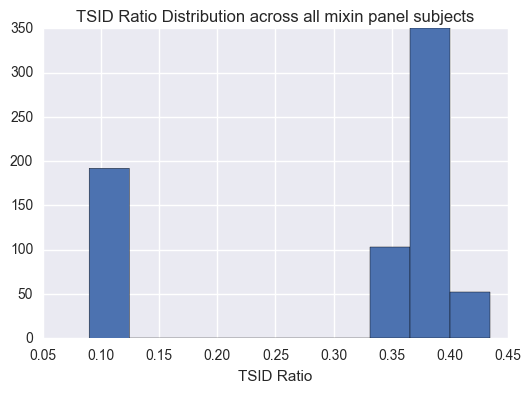

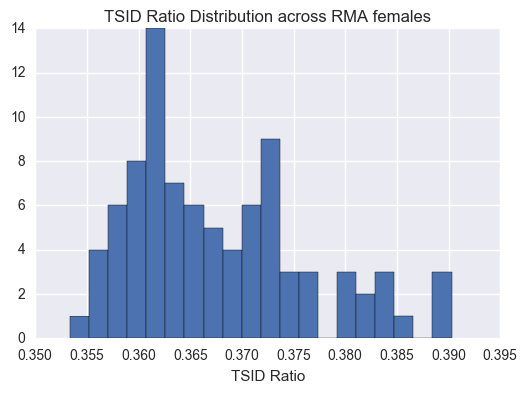

In [19]:
plt.figure()
plt.hist(coverage_df_M1.tsid_ratio)
plt.xlabel('TSID Ratio'), plt.title('TSID Ratio Distribution across all mixin panel subjects')

plt.figure()
plt.hist(coverage_df_RMA.tsid_ratio, bins=20)
plt.xlabel('TSID Ratio'), plt.title('TSID Ratio Distribution across RMA females')

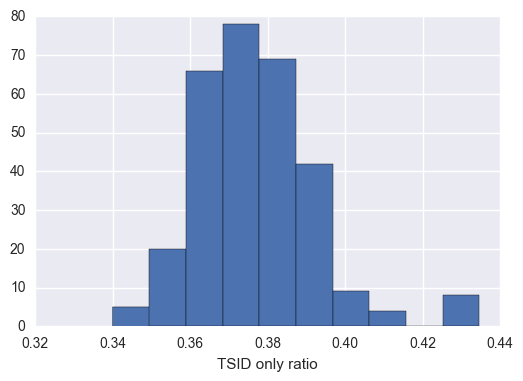

In [20]:
coverage_df_control = coverage_df_f[(coverage_df_f.tsid_ratio < 0.45) & (coverage_df_f.tsid_ratio > 0.3)]
plt.figure()
plt.hist(coverage_df_control.tsid_ratio)
plt.xlabel('TSID only ratio')

92


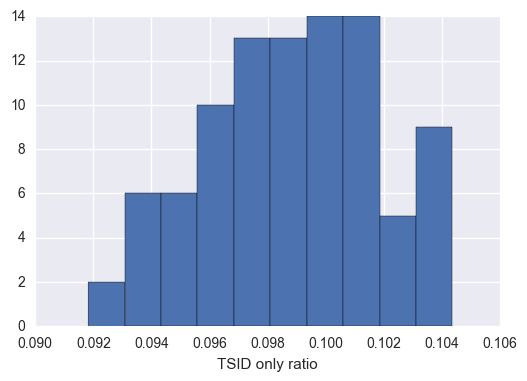

In [87]:
control_10 = coverage_df_f[(coverage_df_f.tsid_ratio < 0.15) & (coverage_df_f.tsid_ratio > 0.05)]
print len(control_10)
plt.figure()
plt.hist(control_10.tsid_ratio)
plt.xlabel('TSID only ratio')

(<matplotlib.text.Text at 0x1137a0090>, <matplotlib.text.Text at 0x116bd9390>)

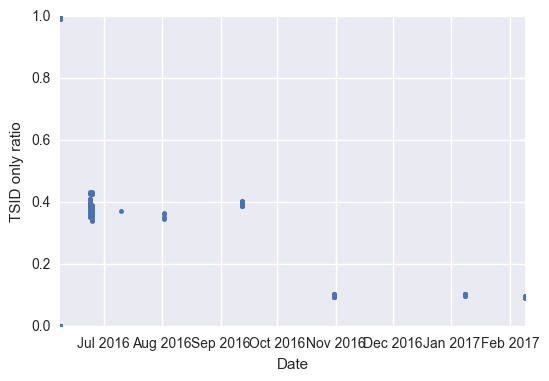

In [115]:
control_10.date_modified
coverage_df_f.columns
plt.figure()
plt.plot(coverage_df_f.date, coverage_df_f.tsid_ratio, '.')
plt.xlabel('Date'), plt.ylabel('TSID only ratio')

In [123]:
get_subjects = control_10.groupby('subject')
[key for key in get_subjects.groups]

['FCLR-GP20-745F',
 'FCLR-NA17-435H',
 'FCLR-GP08-753E',
 'FCLR-NA20-9287',
 'FPWB-0001-2032',
 'FPFC-JABH-UI96',
 'FCLR-GP01-2121',
 'FCLR-GP20-9287',
 'FCLR-NA20-745F',
 'FCLR-NA20-731O',
 'FPWB-0001-418N',
 'FCLR-NA08-753E',
 'FCLR-GP17-435H',
 'FCLR-GP20-731O',
 'FPWB-0001-392T',
 'FCLR-NA01-2121',
 'FCLR-GP22-0112',
 'FPWB-0001-218R',
 'FCLR-GP20-399A',
 'FPWB-0001-315V',
 'FCLR-NA20-399A',
 'FCLR-NA22-0112',
 'FPWB-0001-4210']

,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9,Ex10,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
subject,,,,,,,,,,,,,,,,,,,,,
FCLR-GP01-2121,874,154,350,532,233,400,372,331,198,304,...,482,196,325,257,514,205,312,328,102,242
FCLR-GP08-753E,800,190,300,434,282,400,392,351,208,310,...,397,139,319,248,536,135,268,265,120,252
FCLR-GP17-435H,482,99,194,259,164,255,264,232,93,216,...,300,106,226,146,315,103,174,194,80,142
FCLR-GP20-399A,758,115,361,420,229,337,318,349,206,260,...,455,128,252,256,525,146,273,279,120,229
FCLR-GP20-731O,679,165,314,384,252,332,298,275,152,288,...,360,128,260,235,445,104,205,275,99,235


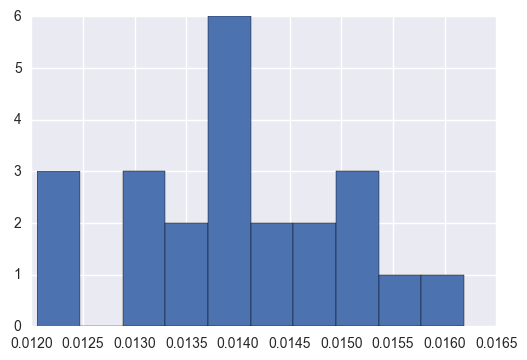

In [105]:
c10 = control_10.drop(['tsid_ratio', 'TSID_only', 'TSO_only'], axis=1)
c10_grouped = c10.groupby('subject').sum()
c10_norm = c10_grouped.div(c10_grouped.sum(axis=1), axis=0)
c10_mean = c10_norm.mean(axis=0)

plt.figure()
plt.hist(c10_norm.Ex60)
c10_grouped.head()


There appears to be a subset of M1 subjects who were run on a very different version of the panel (with a significantly different TSID_only ratio -- around 0.1 instead of 0.38)

(array([  6.,   2.,   7.,   8.,  11.,  18.,  12.,  10.,   4.,   4.]),
 array([ 0.01182062,  0.01257072,  0.01332082,  0.01407093,  0.01482103,
         0.01557113,  0.01632124,  0.01707134,  0.01782144,  0.01857154,
         0.01932165]),
 <a list of 10 Patch objects>)

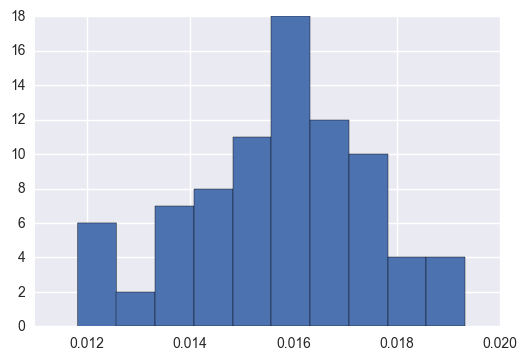

In [101]:
control = coverage_df_control.drop(['tsid_ratio', 'TSID_only', 'TSO_only'], axis=1)
control_grouped = control.groupby('subject').sum()
control_norm = control_grouped.div(control_grouped.sum(axis=1), axis=0)
control_norm.head()
c38_mean = control_norm.mean(axis=0)
plt.figure()
plt.hist(control_norm.Ex15)

(<matplotlib.text.Text at 0x1112166d0>, <matplotlib.text.Text at 0x1111e56d0>)

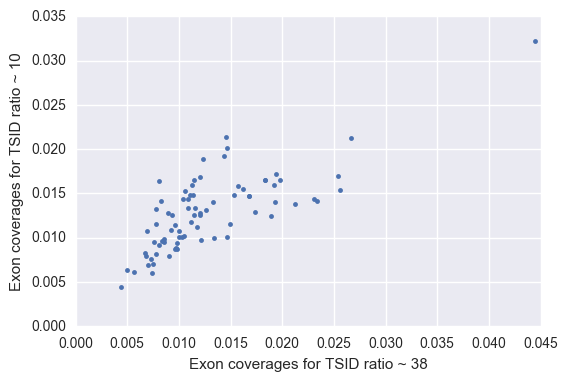

In [104]:
plt.figure()
plt.plot(c38_mean, c10_mean, '.')
plt.xlabel('Exon coverages for TSID ratio ~ 38'), plt.ylabel('Exon coverages for TSID ratio ~ 10')

In [106]:
print len(control_grouped)
gp_control = np.array(control_grouped.values).astype(float)
gp10_control = np.array(c10_grouped.values).astype(float)
print len(gp10_control)
control_grouped.head()

82
23


,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9,Ex10,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
subject,,,,,,,,,,,,,,,,,,,,,
FGPC-0000-444F,2266,306,623,944,591,714,1341,1064,411,715,...,659,272,729,631,847,523,424,622,292,552
FGPC-0000-4495,2220,289,620,792,367,680,1037,841,366,634,...,545,227,589,491,625,434,394,546,272,497
FGPC-0000-453G,2044,224,552,775,508,604,986,775,315,648,...,500,248,498,420,528,324,383,548,214,498
FGPC-0000-606B,2550,316,668,894,488,938,1218,1024,446,790,...,605,243,644,538,710,426,421,610,252,629
FGPC-0000-6079,2431,307,619,1126,599,887,1224,1081,393,931,...,689,333,667,563,827,436,385,657,255,590


In [73]:
%%time
# testing EM algorithm on real subject data
mu_sub, cov_sub = hln_EM(gp_control, logger, 150, 1e-11)

iteration: 1, change: 1.42032189662
iteration: 2, change: 0.0130132733316
iteration: 3, change: 0.00368146315209
iteration: 4, change: 0.00165827014191
iteration: 5, change: 0.000927858136719
iteration: 6, change: 0.000588000952208
iteration: 7, change: 0.000414755022375
iteration: 8, change: 0.000310918184652
iteration: 9, change: 0.000243674199212
iteration: 10, change: 0.000197422710082
iteration: 11, change: 0.000164064327397
iteration: 12, change: 0.00013908005847
iteration: 13, change: 0.000119792075975
iteration: 14, change: 0.000104530582619
iteration: 15, change: 9.22080855056e-05
iteration: 16, change: 8.20894363242e-05
iteration: 17, change: 7.36614713304e-05
iteration: 18, change: 6.65559156794e-05
iteration: 19, change: 6.05020509021e-05
iteration: 20, change: 5.52966730637e-05
iteration: 21, change: 5.07844504633e-05
iteration: 22, change: 4.6844734158e-05
iteration: 23, change: 4.33824866864e-05
iteration: 24, change: 4.03219071773e-05
iteration: 25, change: 3.7601863509

CPU times: user 59.6 s, sys: 14.8 s, total: 1min 14s
Wall time: 59.6 s


In [393]:
mu10, cov10 = hln_EM(gp10_control, logger, 150, 1e-11)

iteration: 1, change: 1.10328622904
iteration: 2, change: 0.024246689816
iteration: 3, change: 0.0076510357011
iteration: 4, change: 0.00377890567024
iteration: 5, change: 0.00226788541734
iteration: 6, change: 0.00151450510065
iteration: 7, change: 0.00108710289925
iteration: 8, change: 0.000821656752535
iteration: 9, change: 0.000645369215395
iteration: 10, change: 0.000522072891093
iteration: 11, change: 0.000432226387784
iteration: 12, change: 0.000364553185142
iteration: 13, change: 0.000312185325778
iteration: 14, change: 0.000270745550859
iteration: 15, change: 0.000237333870212
iteration: 16, change: 0.000209964046186
iteration: 17, change: 0.000187236110851
iteration: 18, change: 0.000168138513032
iteration: 19, change: 0.000151924392153
iteration: 20, change: 0.000138031797439
iteration: 21, change: 0.000126030817784
iteration: 22, change: 0.000115587679383
iteration: 23, change: 0.000106439827135
iteration: 24, change: 9.83782873884e-05
iteration: 25, change: 9.12349624588e-

In [580]:
len(mu_sub), cov_sub

(77, array([[ 0.00570146,  0.00236029,  0.00284861, ...,  0.00148809,
          0.00139169,  0.00228793],
        [ 0.00236029,  0.02746191,  0.01276418, ...,  0.01039226,
          0.00791087,  0.00904221],
        [ 0.00284861,  0.01276418,  0.01405338, ...,  0.01047496,
          0.00670408,  0.00788574],
        ..., 
        [ 0.00148809,  0.01039226,  0.01047496, ...,  0.01568381,
          0.00486377,  0.00441159],
        [ 0.00139169,  0.00791087,  0.00670408, ...,  0.00486377,
          0.00780345,  0.00838836],
        [ 0.00228793,  0.00904221,  0.00788574, ...,  0.00441159,
          0.00838836,  0.04352925]]))

In [358]:
expected_rat = (np.exp(mu10.flatten()) / np.sum(np.exp(mu10.flatten())))
expected_rat

array([ 0.03254244,  0.00640036,  0.01273729,  0.01738601,  0.01087012,
        0.01500165,  0.01448177,  0.01255506,  0.00698843,  0.01169722,
        0.01916957,  0.01289047,  0.0166444 ,  0.00955478,  0.01595713,
        0.00886615,  0.01414141,  0.00830555,  0.01003589,  0.021503  ,
        0.01268426,  0.01571223,  0.01501708,  0.0079757 ,  0.01550737,
        0.00875121,  0.01659933,  0.0089415 ,  0.02164605,  0.00705115,
        0.01327992,  0.0115675 ,  0.01675319,  0.00975378,  0.01353566,
        0.01457265,  0.01288637,  0.00822297,  0.01456377,  0.01614901,
        0.01545301,  0.0092389 ,  0.01941663,  0.01017356,  0.01717467,
        0.00991725,  0.01401766,  0.01500306,  0.01434071,  0.0096661 ,
        0.01268579,  0.01083966,  0.01302635,  0.00959366,  0.01667388,
        0.01436425,  0.00797602,  0.01333427,  0.01706916,  0.01417427,
        0.01015704,  0.01485094,  0.00765322,  0.00984565,  0.01618166,
        0.01346961,  0.0147945 ,  0.01103712,  0.01673969,  0.00

In [357]:
np.savetxt('mu10.csv', mu10, delimiter=',')
np.savetxt('cov10.csv', cov10, delimiter=',')

In [382]:
# generating 95% confidence intervals for simulated samples from mu_sub and cov_sub trained on subjects
numsubs = 300
numreads = 30000
Y_test, X_test = gen_hln_samples(numsubs, numreads, mu10.flatten(), cov10_vari)

In [383]:
Y_test_norm = Y_test / Y_test.sum(axis=1)[:, None]
print Y_test_norm
len(Y_test_norm)

[[ 0.02993333  0.00663333  0.0122     ...,  0.01176667  0.0061      0.00923333]
 [ 0.0321      0.00703333  0.01353333 ...,  0.01153333  0.00323333
   0.00796667]
 [ 0.03106667  0.00506667  0.01143333 ...,  0.0127      0.00396667
   0.01063333]
 ..., 
 [ 0.02533333  0.00716667  0.01606667 ...,  0.01196667  0.0053      0.01093333]
 [ 0.03176667  0.00606667  0.01303333 ...,  0.01306667  0.0039      0.01233333]
 [ 0.0301      0.0061      0.01193333 ...,  0.0125      0.0035      0.01126667]]


300

In [384]:
high_int = np.percentile(Y_test_norm, 97.5, axis=0)
low_int = np.percentile(Y_test_norm, 2.5, axis=0)
sub_099G = np.array(data_dict['315Q']) / float(np.sum(data_dict['315Q']))
print sub_099G < high_int
print sub_099G > low_int

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


## Gibbs Sampling -- hierarchical multinomial logistic model


The full gene product of DMD consists of 78 exons, each with its own copy number in each subject ($\mathbf{C} = \{c_1, c_2, ..., c_{78}\}$), where $c_i \in{1,2,3...}$ For this simple model, assume that the $c_i$ are distributed discrete uniformly with support $ \{1,2,3\}$. 

This model also includes "intensity" values across the exons $\mathbf{X}= \{x_1, x_2,..., x_{78}\}$, and we let $$\mathbf{P} = \dfrac{\mathbf{C}\mathbf{X}}{\sum_i c_ix_i} = \{p_1, p_2, ..., p_{78}\}$$ 
From here we let $k = 78$ to represent the model more generally.

Thus our generative model assumes that the reads for every sequencing run (whether simulated or real) are distributed according to a multinomial distribution with probability vector $\mathbf{P}$. 

As above (with a slight change in notation), we generate an intensity $\mathbf{X}$ for each subject as follows:
$$ \mathbf{v} = \{v_1,...v_{k-1}\} \sim MVN(\mathbf{\mu}, \mathbf{\Sigma}) $$ where $\mathbf{\mu}$ is of length $k-1$ and $\mathbf{\Sigma}$ is a $k-1$ dim covariance vector. 
Set $v_k=0$ and let $$x_i = \dfrac{\exp{v_i}}{\sum_{i=1}^k \exp {v_i}}$$

If we let $\mathbf{Y}$ represent the data from a single subject (where $y_i$ represents the number of reads mapped to exon $i$), we can write the joint distribution as:

$$ 
\begin{align}
\Pr(\mathbf{C}, \mathbf{Y}, \mathbf{v}; \mathbf{\mu, \Sigma}) \;\; &\propto \;\;\prod_{i=1}^k p_i^{y_i} \exp{(-0.5(\mathbf{v} - \mathbf{\mu})' \Sigma^{-1} (\mathbf{v} - \mathbf{\mu}))}  \\
&\propto \;\;\prod_{i=1}^k \left(\dfrac{c_ix_i}{\sum c_ix_i}\right)^{y_i} \exp{(-0.5(\mathbf{v} - \mathbf{\mu})' \Sigma^{-1} (\mathbf{v} - \mathbf{\mu}))}  \\
&\propto \;\; \prod_{i=1}^k \left(\dfrac{c_i \exp{v_i}} {\sum \exp{v_i} \sum \dfrac{c_i \exp{v_i}}{\sum \exp{v_i}}}\right)^{y_i} \exp{(-0.5(\mathbf{v} - \mathbf{\mu})' \Sigma^{-1} (\mathbf{v} - \mathbf{\mu}))}  \\
&\propto \;\;\left(\dfrac{1}{\sum c_i \exp{v_i}}\right)^\mathbb{T} \prod_{i=1}^k (c_i \exp{v_i})^{y_i} \exp{(-0.5(\mathbf{v} - \mathbf{\mu})' \Sigma^{-1} (\mathbf{v} - \mathbf{\mu}))} 
\end{align}
$$
Note that we have left out the normalization constants for the multinomial and MVN distributions and $\mathbb{T} = \sum_i y_i$ represents the total number of reads in $\mathbf{Y}$. 

**Running the Gibbs Sampler**

Initialize the intensities $\mathbf{X}$ as described above from $k-1$ dimensional MVN. Initialize $c_i$ values based on basic prior distribution. If testing (without subject data), we can also generate fake subject data. 

At each iteration $t$, sample $c_i^t$ from the posterior distribution
$$f_{C^t|Y, C_{-i}^t}(c) = \dfrac{\left(\dfrac{1}{\sum c_j \exp{v_j}}\right)^\mathbb{T} \prod_{j=1}^k (c_j \exp{v_j})^{y_j} \vert c_i = c} {\sum_c \left(\dfrac{1}{\sum c_j \exp{v_j}}\right)^\mathbb{T} \prod_{j=1}^k (c_j \exp{v_j})^{y_j} \vert c_i = c}$$ 
where $$ \mathbf{C_{-i}}^t = \{ c_1^t,...c_{i-1}^t, c_{i+1}^{t-1}, ... c_{78}^{t-1} \}$$



Normally this expression would include the prior distribution over $c$ but it easily cancels out as the uniform. (This expression also does not include the multinomial constant or MVN terms). In fact, we can also cancel some of the $v_j$ terms:
$$f_{C^t|Y, C_{-i}^t}(c) = \dfrac{\left(\dfrac{1}{\sum c_j \exp{v_j}}\right)^\mathbb{T} \prod_{j=1}^k c_j^{y_j} \vert c_i = c} {\sum_c \left(\dfrac{1}{\sum c_j \exp{v_j}}\right)^\mathbb{T} \prod_{j=1}^k c_j^{y_j} \vert c_i = c}$$
At the end of each iteration, we also need to resample $\mathbf{v}$.  In our case we have the more complex posterior:

$$ \begin{align}
\Pr(\mathbf{v} | \mathbf{Y}, \mathbf{C}; \mu, \Sigma) &\propto \Pr(\mathbf{v}|\mu, \Sigma) \Pr(\mathbf{Y}, \mathbf{C} | \mathbf{v}) \\
&\propto \exp{(-0.5(\mathbf{v} - \mathbf{\mu})' \Sigma^{-1} (\mathbf{v} - \mathbf{\mu}))}  \prod \left(\dfrac{c_i \exp v_i}{\sum c_i \exp v_i} \right)^{y_i} \\
&\propto \exp{(-0.5(\mathbf{v} - \mathbf{\mu})' \Sigma^{-1} (\mathbf{v} - \mathbf{\mu}))}  \prod \left(\dfrac{\exp v_i}{\sum c_i \exp v_i} \right)^{y_i}
\end{align}
$$

Sampling from this distribution will likely involve some kind of Metropolis-Hastings schema.

**Implementation considerations**: Exponentiating some of our terms can cause under/overflow in Python 

**Solution**: Convert to log space and divide by the maximal likelihood to normalize (and keep values from shrinking too close to 0):

In other words, calculate the value below for each $c_i = c$ and then divide by their sum to normalize.
$$ \exp\left(-\mathbb{T} \log(\sum c_j \exp v_j) +  \sum (y_j \log c_j) - \max_c \left( -\mathbb{T} \log(\sum c_j \exp v_j) +  \sum (y_j \log c_j \right) \right)$$ 

Store the $C^t$ values only for iterations $t=1000... 10,000$. This allows for a burn-in period of 1000 iterations during which the sampling distributions are likely to be least accurate. To reduce auto-correlation, only include every hundredth sampling in final analysis as well. For each exon $i$, count the proportions of samples falling into each possible copy number across the relevant subset of iterations. 


### Next Steps
* Incorporate more complex and representative prior for the copy number distribution (in particular, there should be higher prior probability for 2 copies of exon)
* Determine more accurate estimate of burn-in period (strange log-likelihood behavior, should converge as iterations increase)
* Account for increased likelihood of copy number correlation between neighboring exons
* Consider modifying prior for two exon deletion hotspots (around 45-50 and 18-20)
* **Incorporate step for correcting for mixin-based discrepancies**


In [305]:
def generate_gibbs_df(cnv_support, mu, cov, data=None, cnv=None, sim_reads=3e4, iterations=10000, burn_in=1000,
                      df_wanted=True, exon_labels=None):
    '''Performs Gibbs sampling given a support vector for CNVs, an intensity vector and subject data (optional)
    mu -- means for MVN prior, k-1 len array
    cov -- covariance matrix for MVN prior, k-1 x k-1 array'''
    # initialization of cnv counts and intensity vector
    if cnv is None:
        # generate initial guess for exon copy numbers using uniform prior distribution
        cnv = np.random.choice(cnv_support, size=len(mu)+1) 
    print cnv
    # initialize x vector (adding exp(0) to the end)
    v_vect = np.concatenate((np.random.multivariate_normal(mu.flatten(), cov), [0]))
    X_vect = np.exp(v_vect) / np.sum(np.exp(v_vect))
    
    # pad mu and cov with zeros as necessary for joint prob calcs
    mu_full = np.concatenate((mu.flatten(), [0]))
    cov_full = np.concatenate((np.concatenate((cov, np.zeros((1,len(cov)))), axis=0), 
                               np.zeros((len(cov)+1,1))), axis=1)
    invcov_full = np.concatenate((np.concatenate((np.linalg.inv(cov), np.zeros((1,len(cov)))), axis=0), 
                               np.zeros((len(cov)+1,1))), axis=1)
    # for testing only
    if data is None:
        normed_probs_first = np.multiply(cnv, X_vect) / np.sum(np.multiply(cnv, X_vect))
        data = np.random.multinomial(sim_reads, normed_probs_first)
    
    gibbs_cnv_data = np.zeros((len(X_vect), iterations))
    gibbs_X = np.zeros((iterations, len(X_vect)))
    likelihoods = np.zeros(iterations)
    accepted = np.zeros(iterations)
    
    # begin iterations
    for i in range(iterations):
        if iterations > 20 and (i+1) % (iterations / 20) == 0:
            print 'Finished {} iterations'.format(i)
        # sample all cnv values
        for exon in range(len(X_vect)):
            test = np.zeros(len(cnv_support))
            old = cnv[exon]
            for value in cnv_support:
                cnv[exon] = value
                # get new normed probabilities given test value and priors for exon intensities
                log_probs_norm = np.sum(data) * -1 * np.log(np.sum(np.multiply(cnv, X_vect)))
                log_likelihood = (log_probs_norm + 
                                 np.sum(np.multiply(np.log(cnv), data)))
                test[value - 1] = log_likelihood
            test = test - np.max(test)
            sample_probs = np.exp(test)
            sample_probs = sample_probs / np.sum(sample_probs)
            new_cnv = np.random.choice(cnv_support, p = sample_probs)
            cnv[exon] = new_cnv
            gibbs_cnv_data[exon, i] = new_cnv
            
        # sample new X_vect after updating with data -- use M-H step
        log_mvn_prev = (-0.5 * np.dot(np.dot((v_vect - mu_full).reshape((1,-1)), invcov_full), 
                                         (v_vect - mu_full).reshape((-1,1))))
        joint_previous = (np.sum(data) * -1 * np.log(np.sum(np.multiply(cnv, np.exp(v_vect)))) +
                          np.sum(np.multiply(data, (np.log(cnv) + v_vect))) +
                          log_mvn_prev)
        jump_previous = log_mvn_prev
        v_vect_proposed = np.concatenate((np.random.multivariate_normal(mu.flatten(), cov), [0]))
        jump_proposed = (-0.5 * np.dot(np.dot((v_vect_proposed - mu_full).reshape((1,-1)), invcov_full), 
                                         (v_vect_proposed - mu_full).reshape((-1,1))))
        joint_proposed = (np.sum(data) * -1 * np.log(np.sum(np.multiply(cnv, np.exp(v_vect_proposed)))) +
                          np.sum(np.multiply(data, (np.log(cnv) + v_vect_proposed))) +
                          jump_proposed)
        
        log_test_ratio = joint_proposed + jump_previous - joint_previous - jump_proposed

        jump_chance = min(1.0, np.exp(log_test_ratio))
        if np.random.rand() < jump_chance:
            v_vect = v_vect_proposed
            accepted[i] = 1
        else:
            accepted[i] = 0
            
        X_vect = np.exp(v_vect) / np.sum(np.exp(v_vect))
        gibbs_X[i] = X_vect
        
        likelihoods[i] = (np.sum(data) * -1 * np.log(np.sum(np.multiply(cnv, np.exp(v_vect)))) +
                          np.sum(np.multiply(data, (np.log(cnv) + v_vect))) +
                          (-0.5 * np.dot(np.dot((v_vect - mu_full).reshape((1,-1)), invcov_full), 
                                         (v_vect - mu_full).reshape((-1,1)))))
    
    print 'Acceptance ratio: {}'.format(np.mean(accepted))
    # get proportions using burn-in of 1000 iterations 
    gibbs_data_results = np.zeros((len(X_vect), len(cnv_support)))
    for index in range(len(X_vect)):
        # exclude samples before burn in and then take only every 100th sample to reduce autocorrelation
        gibbs_slice = gibbs_cnv_data[index][burn_in:][::100]
        gibbs_data_results[index] = np.bincount(gibbs_slice.astype(np.int64), 
                                                minlength=len(cnv_support)+1)[1:]
    gibbs_data_results = gibbs_data_results / float(len(gibbs_slice))
    
    # return df for easier visualization
    if df_wanted:
        gibbs_df = pd.DataFrame(gibbs_data_results, columns =['copy_{}'.format(cnv) for cnv in cnv_support])
        gibbs_df['Exon'] = exon_labels
        return gibbs_cnv_data, gibbs_X, gibbs_data_results, likelihoods, gibbs_df
    
    return gibbs_cnv_data, gibbs_X, gibbs_data_results, likelihoods

In [417]:
def get_conditional_mvn(mu, cov, index, full_x, use_diag=False):
    """Returns mu and cov for conditional normal distribution for single unknown value"""
    mu_1 = mu[index]
    mu_2 = np.delete(mu, index)
    x_1 = full_x[index]
    a = np.delete(full_x, index)
    cov_11 = cov[index, index]
    cov_12 = np.concatenate((cov[index][:index], cov[index][(index+1):])).reshape((1, -1))
    cov_21 = np.concatenate((cov[:,index][:index], cov[:, index][(index+1):])).reshape((-1,1))
    
    cov_22_t = np.concatenate((cov[:index, :index], cov[:index, (index+1):]), axis=1)
    cov_22_b = np.concatenate((cov[(index+1):, :index], cov[(index+1):, (index+1):]), axis=1)
    cov_22 = np.concatenate((cov_22_t, cov_22_b), axis=0)
    cov_22_inv = np.linalg.pinv(cov_22) if use_diag else np.linalg.inv(cov_22)
    
    mu_bar = mu_1 + np.dot(np.dot(cov_12, cov_22_inv), (a - mu_2).reshape((-1,1)))
    cov_bar = cov_11 - np.dot(np.dot(cov_12, cov_22_inv), cov_21)
    
    return mu_bar.flatten()[0], cov_bar.flatten()[0]

In [377]:
def log_joint_likelihood(cnv_vect, v_vect, mu, invcov, data):
    log_joint = (np.sum(data) * -1 * np.log(np.sum(np.multiply(cnv_vect, np.exp(v_vect)))) +
                 np.sum(np.multiply(data, (np.log(cnv_vect) + v_vect))) +
                 (-0.5 * np.dot(np.dot((v_vect - mu).reshape((1,-1)), invcov), 
                                (v_vect - mu).reshape((-1,1)))))
    return log_joint

In [423]:
def metro_hastings(cnv_support, mu, cov, data=None, cnv=None, sim_reads=3e4, iterations=10000, burn_in=1000,
                   df_wanted=True, exon_labels=None, use_diag_approx=True):
    '''Performs metropolis hastings sampling given a support vector for CNVs, an intensity vector and 
    subject data (optional)
    mu -- means for MVN prior, k-1 len array
    cov -- covariance matrix for MVN prior, k-1 x k-1 array'''
    # initialization of cnv counts and intensity vector
    if cnv is None:
        # generate initial guess for exon copy numbers using uniform prior distribution
        cnv = np.random.choice(cnv_support, size=len(mu)+1) 
    print cnv
    invcov = np.linalg.inv(cov)
    if use_diag_approx:
        cov = np.diag(np.diagonal(cov))
        invcov = np.linalg.inv(cov)
        
    # pad mu and cov with zeros as necessary for joint prob calcs
    mu_full = np.concatenate((mu.flatten(), [0]))
    invcov_full = np.concatenate((np.concatenate((invcov, np.zeros((1,len(cov)))), axis=0), 
                               np.zeros((len(cov)+1,1))), axis=1)

    # initialize x vector (adding exp(0) to the end)
    v_vect = np.concatenate((np.random.multivariate_normal(mu.flatten(), cov), [0]))
    X_vect = np.exp(v_vect) / np.sum(np.exp(v_vect))
    # for testing only
    if data is None:
        normed_probs_first = np.multiply(cnv, X_vect) / np.sum(np.multiply(cnv, X_vect))
        data = np.random.multinomial(sim_reads, normed_probs_first)
    
    mh_cnv_data = np.zeros((len(X_vect), iterations))
    mh_v = np.zeros((iterations, len(X_vect)))
    accepted = np.zeros((iterations, len(X_vect)))
        
    likelihoods = np.zeros(iterations)
    
    # begin iterations
    for i in range(iterations):
        if iterations > 20 and (i+1) % (iterations / 20) == 0:
            print 'Finished {} iterations'.format(i)
        for exon in range(len(X_vect)):
            v_vect_proposed = np.copy(v_vect)
            copy_proposed = np.random.choice(cnv_support)
            cnv_proposed = np.copy(cnv)
            cnv_proposed[exon] = copy_proposed
            
            if exon != (len(X_vect) - 1):
                if use_diag_approx:
                    mu_bar = mu[exon]
                    cov_bar = cov[exon, exon]
                else:
                    mu_bar, cov_bar = get_conditional_mvn(mu, cov, exon, v_vect[:-1], use_diag=use_diag_approx)
                v_proposed = np.random.normal(mu_bar, np.sqrt(cov_bar))
                v_vect_proposed[exon] = v_proposed

                jump_proposed = -(v_proposed - mu_bar) ** 2 / (2 * cov_bar)
                jump_previous = -(v_vect[exon] - mu_bar) ** 2 / (2 * cov_bar)
            else:
                jump_proposed = 0
                jump_previous = 0
                
            joint_proposed = log_joint_likelihood(cnv_proposed, v_vect_proposed, mu_full, invcov_full, data)
            joint_previous = log_joint_likelihood(cnv, v_vect, mu_full, invcov_full, data)
            log_test_ratio = joint_proposed + jump_previous - joint_previous - jump_proposed

            jump_chance = min(1.0, np.exp(log_test_ratio))
            if np.random.rand() < jump_chance:
                cnv = cnv_proposed
                v_vect = v_vect_proposed
                accepted[i, exon] = 1
            else:
                accepted[i,exon] = 0
            
            mh_cnv_data[exon, i] = cnv[exon]
            mh_v[i, exon] = v_vect[exon]
            
        
        likelihoods[i] = log_joint_likelihood(cnv, v_vect, mu_full, invcov_full, data)
    
    # get proportions using burn-in of 1000 iterations 
    mh_data_results = np.zeros((len(X_vect), len(cnv_support)))
    for index in range(len(X_vect)):
        # exclude samples before burn in and then take only every 100th sample to reduce autocorrelation
        mh_slice = mh_cnv_data[index][burn_in:][::100]
        mh_data_results[index] = np.bincount(mh_slice.astype(np.int64), 
                                                minlength=len(cnv_support)+1)[1:]
    mh_data_results = mh_data_results / float(len(mh_slice))
    
    print 'Acceptance ratio: {}'.format(np.mean(accepted))
    # return df for easier visualization
    if df_wanted:
        mh_df = pd.DataFrame(mh_data_results, columns =['copy_{}'.format(cnv) for cnv in cnv_support])
        mh_df['Exon'] = exon_labels
        return mh_cnv_data, mh_v, mh_data_results, likelihoods, mh_df
    
    return mh_cnv_data, mh_v, mh_data_results, likelihoods

## Rerunning Gibbs Sampling with varying intensity vectors
The gibbs sampling done here will be performed with intensity vectors based on subsets of subjects with similar TSID_only ratios to the individual test subject. 

In [29]:
gibbs_columns = ['subject'] + [column for column in coverage_df.columns if 'Ex' in column]

In [40]:
# function for reshaping data frames so that exons are observations (rows) and subjects are variables (columns)
# make sure datetimes have been converted to datetime objects before using
def reshape_df(df, include_stats=False, subject_droplist=None, df_counts_wanted=False):
    df_grouped = df.groupby(['subject']).sum()
    df_norm = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    df_norm = df_norm.transpose().reset_index()
    df_norm.rename(columns={'index': 'Exon'}, inplace=True)

    if subject_droplist:
        for subject in subject_droplist:
            df_norm.drop(subject, axis=1, inplace=True)
    if include_stats:
        df_norm['Mean'] = df_norm.mean(axis=1)
        df_norm['SD'] = df_norm.std(axis=1)
    if df_counts_wanted:
        return df_norm, df_grouped
    else:
        return df_norm

In [41]:
# use RMA samples for initial intensity vector -- note that all RMA individuals used the M1 mixin panel
# this is only the females in RMA
print coverage_df_RMA.sequencer.unique()
rma_ex = coverage_df_RMA[gibbs_columns]
RMA_norm = reshape_df(rma_ex, include_stats=True)
RMA_norm.head()
X_probs = np.array(RMA_norm.Mean)
print len(X_probs)
X_probs
RMA_norm.head()

['M1']
78


subject,Exon,FRMR-0070-444H,FRMR-0081-1987,FRMR-0085-579V,FRMR-00AG-860T,FRMR-00AW-8645,FRMR-00BB-772T,FRMR-00CS-821F,FRMR-00DM-853C,FRMR-00GC-803L,...,FRMR-00MS-704S,FRMR-00NC-7632,FRMR-00SA-876L,FRMR-00SB-851W,FRMR-00SC-714V,FRMR-00SD-679G,FRMR-00ST-841F,FRMR-00TS-8464,Mean,SD
0,Ex1,0.039897,0.043291,0.038417,0.043620,0.039123,0.040485,0.039708,0.040878,0.045125,...,0.043579,0.046018,0.038485,0.039989,0.043555,0.037319,0.045118,0.040692,0.042155,0.002726
1,Ex2,0.004678,0.005073,0.005041,0.005331,0.005397,0.004894,0.004709,0.004108,0.005038,...,0.005191,0.004444,0.004449,0.005499,0.004628,0.006340,0.005937,0.005740,0.005039,0.000552
2,Ex3,0.012082,0.011451,0.011480,0.011187,0.011614,0.012285,0.012389,0.012783,0.012536,...,0.012038,0.012118,0.012041,0.012671,0.011442,0.010723,0.014282,0.013281,0.012197,0.000780
3,Ex4,0.018110,0.017262,0.017888,0.022636,0.017079,0.015429,0.021727,0.019059,0.020194,...,0.021530,0.021213,0.019180,0.017283,0.019932,0.015830,0.021847,0.021208,0.019499,0.002122
4,Ex5,0.009605,0.010441,0.010781,0.012763,0.009086,0.009238,0.011827,0.011468,0.009755,...,0.009813,0.008397,0.010155,0.009478,0.009228,0.010383,0.010177,0.010012,0.010142,0.000944


In [42]:
# more refined subset based on tsid_ratios
rma38 = rma_subset[gibbs_columns]
rma38_norm = reshape_df(rma38, include_stats=True)
X_probs38 = np.array(rma38_norm.Mean)
rma38_norm.head()

NameError: name 'rma_subset' is not defined

In [741]:
test_scale = 3e4
test_mse = []
# print scipy.stats.dirichlet.mean(test_scale * np.array(rma38_norm.Mean))
print np.power(np.array(rma38_norm.SD), 2)
print scipy.stats.dirichlet.var(1.7e4 * np.array(rma38_norm.Mean))
# for i in range(len(rma38_norm.columns) - 3):
#     test_pdf.append(scipy.stats.dirichlet.pdf(rma38_norm[rma38_norm.columns[i+1]], test_scale * rma38_norm.Mean))
# test_pdf
for i in np.linspace(0.1, 10, 100):
    test_scale = i * 1e4
    sample_var = np.power(np.array(rma38_norm.SD)[1:], 2)
    dir_var = scipy.stats.dirichlet.var(test_scale * np.array(rma38_norm.Mean)[1:])
    mse = np.mean(np.square(sample_var - dir_var))
    test_mse.append(mse)

[  4.51288618e-06   1.04841442e-07   1.52665496e-07   1.94712220e-06
   4.64597497e-07   2.64857077e-06   2.76699878e-06   5.53924561e-07
   2.39413775e-07   6.70546053e-07   4.36535102e-07   3.14621056e-07
   6.33629856e-07   6.68560886e-08   1.07180846e-06   3.07127719e-07
   1.09843232e-06   1.21862016e-07   1.21106937e-06   1.66611969e-06
   7.98581676e-07   6.21120498e-07   5.67704903e-07   6.44884301e-07
   6.15230736e-07   8.97684875e-07   2.34245009e-06   2.31578253e-07
   7.98362370e-07   4.22333112e-07   1.38605569e-07   5.25180328e-07
   1.35902452e-06   1.02318248e-06   6.62485467e-07   1.12283187e-06
   1.56995061e-06   8.49927042e-07   2.27578872e-07   5.86724035e-07
   2.43451361e-07   7.89526673e-07   1.03612278e-06   1.68796636e-06
   2.06001009e-06   5.90821403e-07   1.20270314e-06   5.93455486e-07
   2.56890064e-06   4.11123915e-07   9.05985572e-07   7.84081775e-07
   4.27119593e-07   4.21728937e-07   6.08296535e-07   2.03837445e-07
   1.15396492e-07   1.93552139e-07

In [740]:
np.linspace(0.1, 10, 100)[np.argmin(test_mse)]

1.7000000000000002

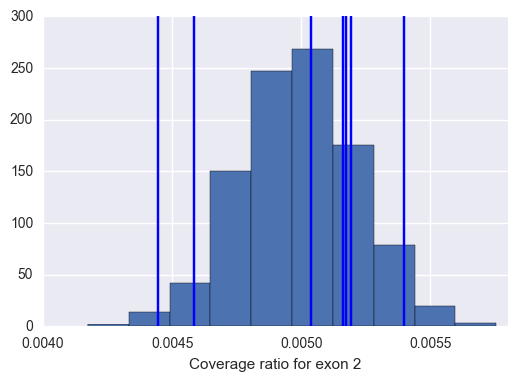

In [801]:
test_scale = 9e4
test_many = np.random.dirichlet(test_scale * np.array(rma38_norm.Mean), 1000)
plt.figure()
plt.hist(test_many[:, 1])
plt.xlabel('Coverage ratio for exon 2')
for cover in rma38_norm.iloc[1][1:-2]:
    plt.axvline(x=cover)

In [346]:
# subset for subject J0F1 
m1_43 = m1_subset43[gibbs_columns]
m1_43_norm = reshape_df(m1_43, include_stats=True)
X_probs43 = np.array(m1_43_norm.Mean)
m1_43_norm.head()

subject,Exon,FGPC-1PR1-SON4,FGPC-INSR-YI4C,Mean,SD
0,Ex1,0.050868,0.050952,0.050910,0.000042
1,Ex2,0.006013,0.006189,0.006101,0.000088
2,Ex3,0.011639,0.011508,0.011573,0.000066
3,Ex4,0.018458,0.020505,0.019482,0.001024
4,Ex5,0.010982,0.012079,0.011531,0.000549


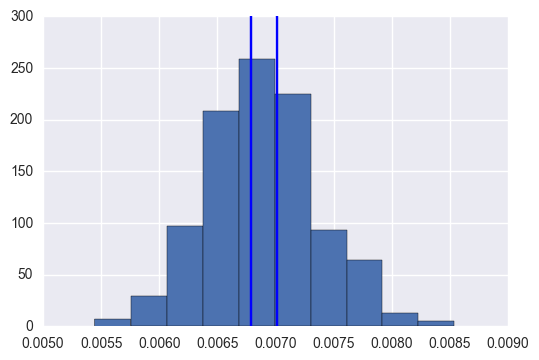

In [719]:
test_scale = 3e4
test_many = np.random.dirichlet(test_scale * np.array(m1_43_norm.Mean), 1000)
plt.figure()
plt.hist(test_many[:, 12])
for cover in m1_43_norm.iloc[12][1:-2]:
    plt.axvline(x=cover)

In [33]:
# generating coverage counts for superset of exons
reload(cov)
test_subjects_num = cov.coverageMatrix().create_coverage_matrix(tsid_exons_merged, 
                                                                tsid_exon_labels, bam_dir='../bams/test_subjects')

NameError: name 'tsid_exons_merged' is not defined

## Testing real subjects

In [310]:
%%time
# generating coverage counts for only primary transcript exons, note that this will run slowly if coverageMatrix()
# code has not been updated 
reload(cov)
test_subjects_prim = cov.coverageMatrix().create_coverage_matrix(DMD_exons_merged, 
                                                                 exon_labels, bam_dir='../bams/test_subjects')

TSO only: 1660 intervals over 356613 bp
TSID only: 154 intervals over 161606 bp

Creating coverage_matrix with 9 subjects
------------------------------------------------------------
Time per 1 unit/s: 7.40 sec, Counts: 1/9
TE: 7.40 sec, ETR: 59.19 sec, ETT: 1 min: 6.59 sec 
----------------------------------------
Time per 1 unit/s: 5.67 sec, Counts: 2/9
TE: 13.07 sec, ETR: 45.76 sec, ETT: 58.83 sec 
----------------------------------------
Time per 1 unit/s: 6.87 sec, Counts: 3/9
TE: 19.95 sec, ETR: 39.89 sec, ETT: 59.84 sec 
----------------------------------------
Time per 1 unit/s: 7.46 sec, Counts: 4/9
TE: 27.41 sec, ETR: 34.26 sec, ETT: 1 min: 1.67 sec 
----------------------------------------
Time per 1 unit/s: 7.36 sec, Counts: 5/9
TE: 34.77 sec, ETR: 27.81 sec, ETT: 1 min: 2.58 sec 
----------------------------------------
Time per 1 unit/s: 4.86 sec, Counts: 6/9
TE: 39.63 sec, ETR: 19.81 sec, ETT: 59.44 sec 
----------------------------------------
Time per 1 unit/s: 4.72 se

CPU times: user 52.2 s, sys: 3.34 s, total: 55.6 s
Wall time: 1min 2s


In [311]:
# test_subjects = pd.DataFrame(coverage_matrix[1:], columns=coverage_matrix[0])
# test_subjects_num = test_subjects.apply(lambda x: pd.to_numeric(x, errors='ignore'))
test_subjects_prim.date_modified = pd.to_datetime(test_subjects_prim.date_modified, unit='s')
test_subjects_prim['date'] = test_subjects_prim.date_modified.dt.date
# drop unnecessary columns (is_rerun, and coding regions)
# test_subjects_num.drop(['is_rerun'], axis=1, inplace=True)
test_subjects_sub = test_subjects_prim[gibbs_columns]
# test_subjects_rel = test_subjects_num[test_subjects_num.columns[:12]]
# # test_subjects_rel['tsid_ratio'] = test_subjects_rel.TSID_only / (test_subjects_rel.TSID_only + test_subjects_rel.TSO_only)
# print test_subjects_num.subject.unique()
# print test_subjects_num.date.unique()
# test_subjects_rel.head()

In [312]:
# test_subjects_prim.columns
test_subjects_grouped = test_subjects_prim.groupby('sample').sum()
test_subjects_grouped['tsid_ratio'] = test_subjects_grouped.TSID_only / (test_subjects_grouped.TSID_only + test_subjects_grouped.TSO_only)
test_subjects_grouped.head()

,is_rerun,TSID_only,TSO_only,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,...,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79,TSID_ratio,tsid_ratio
sample,,,,,,,,,,,,,,,,,,,,,
FCLR-NA04-099G_1-M1-1,False,56822,490374,887,136,437,498,264,425,400,...,298,242,555,170,284,305,143,311,0.415387,0.103842
FCLR-NA04-315Q_1-M1-1,False,40701,361748,682,99,289,364,229,293,241,...,216,212,401,126,224,229,66,199,0.404513,0.101133
FCLR-NA05-264O_1-M1-1,False,46927,423451,752,93,262,463,257,345,330,...,255,216,478,132,268,248,79,226,0.398964,0.099764
FGPC-0000-444F_1-M1-1,False,233047,385993,2266,306,623,944,591,714,1341,...,729,631,847,523,424,622,292,553,1.505760,0.376465
FGPC-0000-444F_dup_1-M1-1,False,233047,385993,2266,306,623,944,591,714,1341,...,729,631,847,523,424,622,292,553,1.505760,0.376465


In [313]:
subject_norm, subject_counts = reshape_df(test_subjects_sub, df_counts_wanted=True)
subject_counts.head()

,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,Ex9,Ex10,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
subject,,,,,,,,,,,,,,,,,,,,,
FCLR-NA04-099G,887,136,437,498,264,425,400,387,224,319,...,472,176,298,242,555,170,284,305,143,311
FCLR-NA04-315Q,682,99,289,364,229,293,241,303,126,289,...,347,122,216,212,401,126,224,229,66,199
FCLR-NA05-264O,752,93,262,463,257,345,330,308,155,246,...,347,139,255,216,478,132,268,248,79,226
FGPC-0000-444F,2266,306,623,944,591,714,1341,1064,411,715,...,659,272,729,631,847,523,424,622,292,553
FGPC-0000-444F_dup,2266,306,623,944,591,714,1341,1064,411,715,...,659,272,729,631,847,523,424,622,292,553


In [64]:
subject_norm.head(68)

subject,Exon,FCLR-NA04-315Q,FGPC-0000-444F,FGPC-0000-444F_dup,FGPC-4ZPF-J0F1,FGPC-4ZPF-J0F1_del,FPWB-0000-822R,FPWB-0000-822R_del
0,Ex1,0.032937,0.040142,0.040014,0.048767,0.049481,0.045417,0.046524
1,Ex2,0.004781,0.005421,0.005403,0.003490,0.003541,0.003923,0.004019
2,Ex3,0.013957,0.011036,0.011001,0.011386,0.011553,0.011571,0.011853
3,Ex4,0.017579,0.016723,0.016670,0.016502,0.016744,0.017075,0.017491
4,Ex5,0.011060,0.010469,0.010436,0.011179,0.011342,0.009381,0.009610
5,Ex6,0.014150,0.012648,0.012608,0.016384,0.016624,0.017485,0.017912
6,Ex7,0.011639,0.023756,0.023680,0.021293,0.021605,0.022229,0.022772
7,Ex8,0.014633,0.018849,0.018789,0.017833,0.018094,0.018960,0.019423
8,Ex9,0.006085,0.007281,0.007258,0.007600,0.007712,0.006857,0.007025
9,Ex10,0.013957,0.012666,0.012626,0.013456,0.013653,0.014597,0.014953


In [316]:
data_dict = {subject.split('-')[-1]: np.array(subject_counts.loc[subject]) for subject in test_subjects_sub.subject.unique()}
print data_dict['099G']

[887 136 437 498 264 425 400 387 224 319 551 370 533 232 504 260 398 247
 309 626 359 414 410 246 433 275 424 157 324 101 137 379 514 280 414 379
 362 199 377 461 478 294 600 281 510 300 399 529 403 300 377 339 422 252
 484 354 210 360 464 499 282 400 237 275 448 381 403 359 472 176 298 242
 555 170 284 305 143 311]


In [390]:
cov10_fixed = 1.5*np.diag(np.diagonal(cov10))
cov10[76,76] = 1.5* cov10[76,76]

In [424]:
%%prun
cnv_support = [1,2,3]
cnv_start = 2.0 * np.ones(78)
mh_data_315Q, mhX_315Q, mh_data_results_315Q, mh_logliks_315Q, mh_df_315Q = metro_hastings(cnv_support, 
                                                                        mu10, cov10, cnv=cnv_start, data=data_dict['315Q'], 
                                                                        iterations=10000, exon_labels=exon_labels, 
                                                                                           use_diag_approx=True)

[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
Acceptance ratio: 0.170797435897
 

In [325]:
%%time
cnv_support = [1,2,3]
gibbs_data_315Q, gibbsX_315Q, gibbs_data_results_315Q, gibbs_logliks_315Q, gibbs_df_315Q = generate_gibbs_df(cnv_support, 
                                                                        mu10, cov10, data=data_dict['315Q'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 3 2 2 3 3 1 1 2 3 3 2 2 2 3 3 1 1 3 2 1 3 2 3 3 1 2 3 3 3 2 1 1 3 2 1 2
 1 2 1 1 2 1 3 3 3 1 2 1 3 1 1 1 1 2 1 3 1 2 2 1 2 1 1 3 1 3 1 2 3 2 2 2 3
 1 1 3 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
Acceptance ratio: 0.0006
CPU times: user 1min 15s, sys: 2.48 s, total: 1min 17s
Wall time: 1min 16s


In [46]:
# reference: http://chrisalbon.com/python/matplotlib_percentage_stacked_bar_plot.html
def create_stacked_bars(df, title): 
    f, ax = plt.subplots(1, figsize=(15,7))
    bar_width = 1

    bar_l = [i for i in range(len(df['copy_1']))] 
    tick_pos = [i + bar_width for i in bar_l] 

    # loop through these later
    # Create a bar chart in position bar_1
    ax.bar(bar_l, df.copy_1, label='1 Copy', alpha=0.9, color='#019600', width=bar_width, edgecolor='white')

    ax.bar(bar_l, df.copy_2, bottom=df.copy_1, label='2 Copy', alpha=0.9, color='#3C5F5A', width=bar_width,
           edgecolor='white')

    ax.bar(bar_l, df.copy_3, bottom=[i+j for i,j in zip(df.copy_1, df.copy_2)], label='3 Copy',
           alpha=0.9, color='#219AD8', width=bar_width, edgecolor='white')

    # getting just the number designation for each exon group as its label
    plt.xticks(tick_pos, df['Exon'].str.split('x').str[-1])
    ax.set_ylabel("Probabilities")
    ax.set_xlabel("Exons")

    plt.xlim([min(tick_pos)-2*bar_width, max(tick_pos)+bar_width])
    plt.ylim(-0.1, 1.1)

    plt.setp(plt.gca().get_xticklabels(), rotation=60, horizontalalignment='right')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               fancybox=True, shadow=True, ncol=3)
    plt.title(title)
    plt.show()

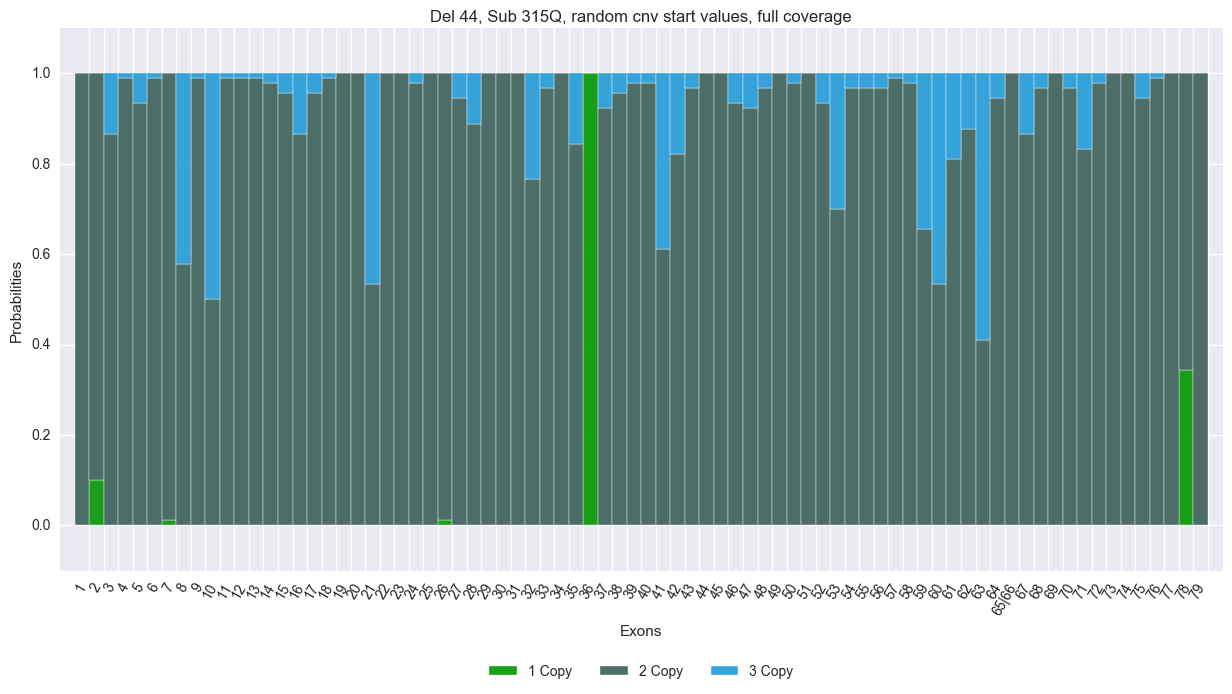

In [425]:
create_stacked_bars(mh_df_315Q, 'Del 44, Sub 315Q, random cnv start values, full coverage')

In [356]:
cov10sorted = np.sort(cov10.flatten())
print len(cov10sorted)
np.where(cov10sorted == cov10[35,76])[0][0] / float(len(cov10sorted))

5929


0.96272558610220949

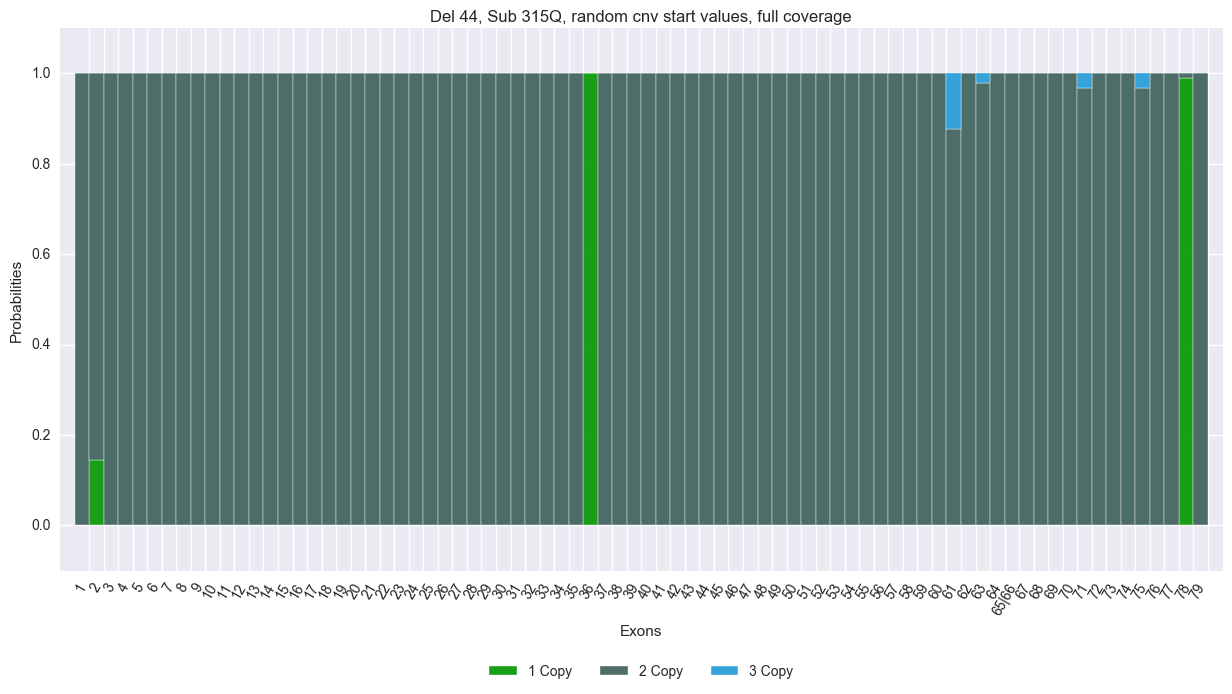

In [326]:
create_stacked_bars(gibbs_df_315Q, 'Del 44, Sub 315Q, random cnv start values, full coverage')

(<matplotlib.text.Text at 0x11506a890>, <matplotlib.text.Text at 0x1159d41d0>)

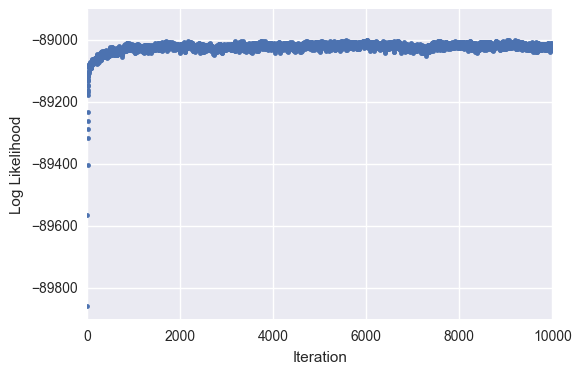

In [403]:
plt.figure()
plt.plot(range(len(mh_logliks_315Q)), mh_logliks_315Q, '.')
plt.xlabel('Iteration'), plt.ylabel('Log Likelihood')

(<matplotlib.text.Text at 0x118a8c650>, <matplotlib.text.Text at 0x11575e2d0>)

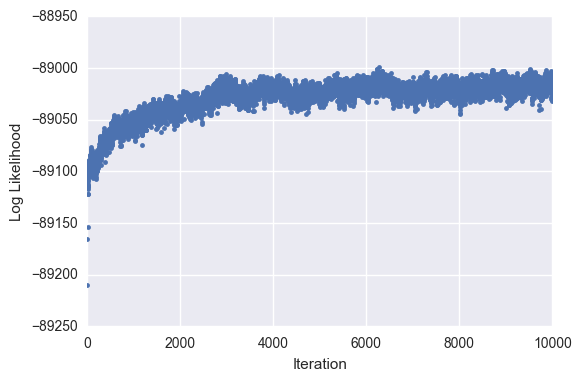

In [406]:
plt.figure()
plt.plot(range(len(mh_logliks_315Q)), mh_logliks_315Q, '.')
plt.xlabel('Iteration'), plt.ylabel('Log Likelihood')

In [441]:
%%time
cnv_support = [1,2,3]
cnv_start = 2.0 * np.ones(78)
mh_data_099G, mhX_099G, mh_data_results_099G, mh_logliks_099G, mh_df_099G = metro_hastings(cnv_support, 
                                                                        mu10, cov10, cnv=cnv_start, data=data_dict['099G'], 
                                                                        iterations=10000, exon_labels=exon_labels,
                                                                        use_diag_approx=True)

[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
Acceptance ratio: 0.147679487179
CPU times: user 1min 24s, sys: 579 ms, total: 1min 24s
Wall time: 1min 25s


In [329]:
%%time
cnv_support = [1,2,3]
gibbs_data_099G, gibbsX_099G, gibbs_data_results_099G, gibbs_logliks_099G, gibbs_df_099G = generate_gibbs_df(cnv_support, 
                                                                        mu10, cov10, data=data_dict['099G'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[1 2 1 3 3 1 2 2 2 2 2 2 2 1 2 3 1 3 3 1 3 1 3 3 3 3 3 3 3 2 2 2 1 2 3 2 2
 2 2 3 3 2 1 3 2 3 2 2 1 2 3 2 2 1 2 1 2 2 1 3 3 3 1 1 3 2 1 3 2 1 1 2 2 3
 3 1 1 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
Acceptance ratio: 0.0004
CPU times: user 1min 15s, sys: 2.48 s, total: 1min 17s
Wall time: 1min 15s


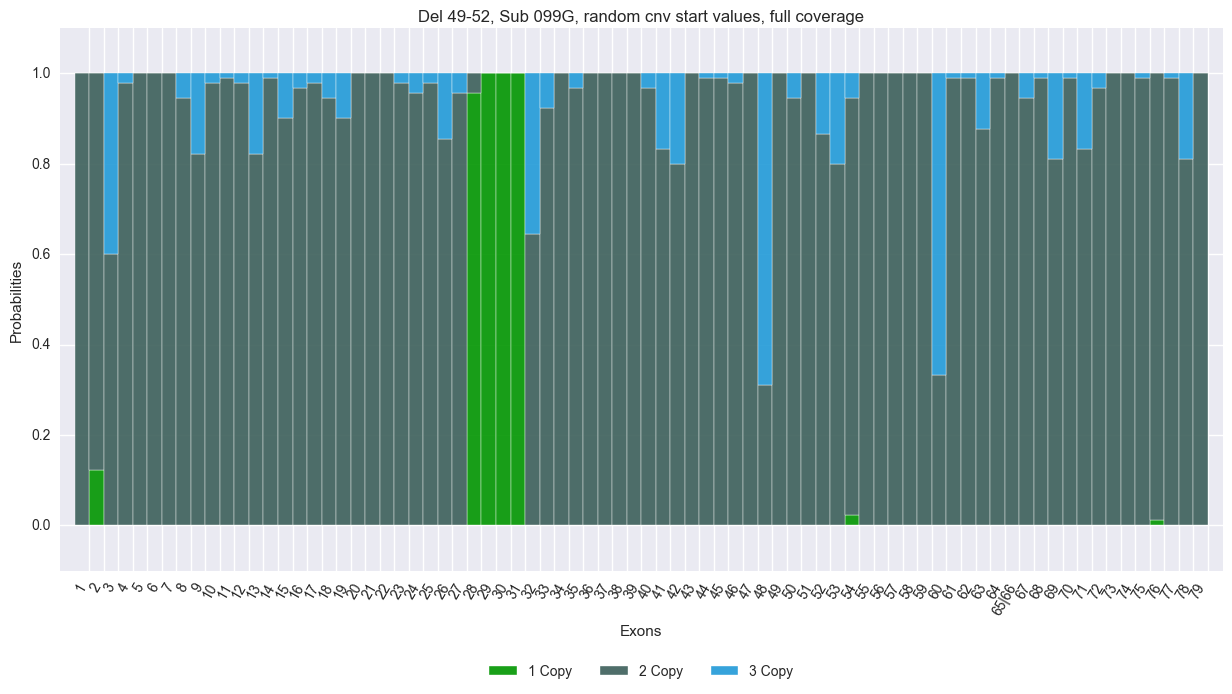

In [447]:
create_stacked_bars(mh_df_099G, 'Del 49-52, Sub 099G, random cnv start values, full coverage')

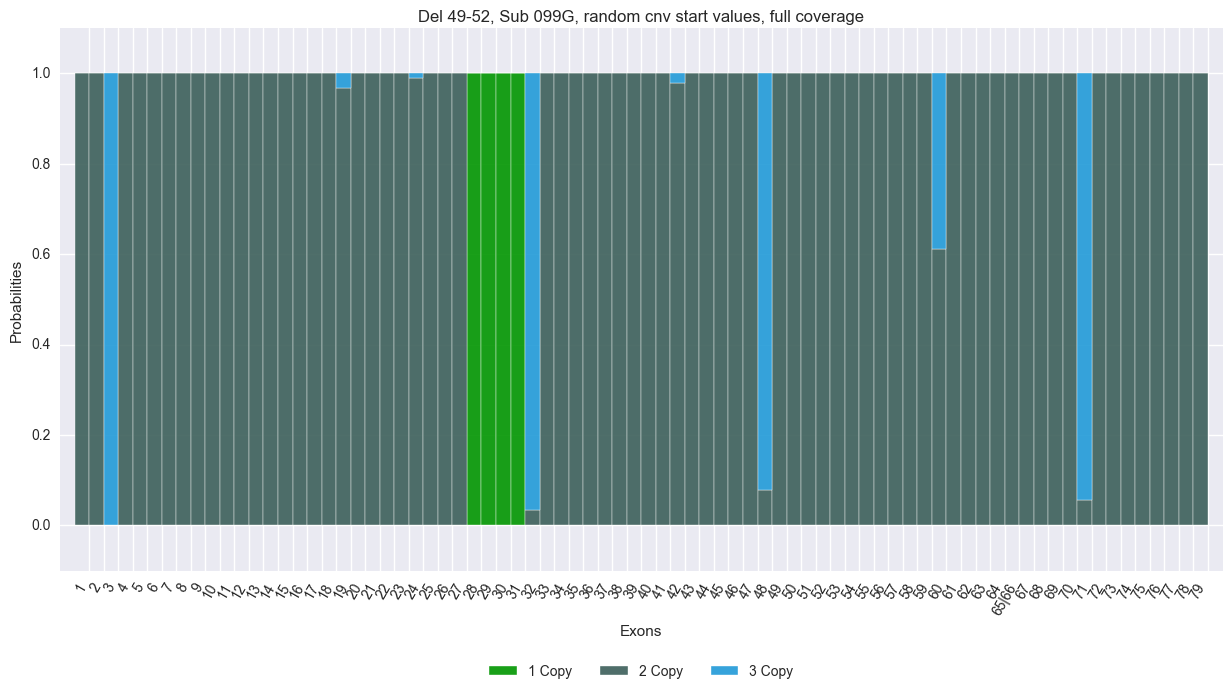

In [410]:
create_stacked_bars(gibbs_df_099G, 'Del 49-52, Sub 099G, random cnv start values, full coverage')

In [428]:
%%time
cnv_support = [1,2,3]
cnv_start = 2.0 * np.ones(78)
mh_data_264O, mhX_264O, mh_data_results_264O, mh_logliks_264O, mh_df_264O = metro_hastings(cnv_support, 
                                                                        mu10, cov10, cnv=cnv_start, data=data_dict['264O'], 
                                                                        iterations=10000, exon_labels=exon_labels,
                                                                        use_diag_approx=True)

[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
Acceptance ratio: 0.164033333333
CPU times: user 1min 6s, sys: 324 ms, total: 1min 7s
Wall time: 1min 7s


In [339]:
%%time
cnv_support = [1,2,3]
cnv_start = 2.0 * np.ones(78)
gibbs_data_264O, gibbsX_264O, gibbs_data_results_264O, gibbs_logliks_264O, gibbs_df_264O = generate_gibbs_df(cnv_support, 
                                                                        mu10, cov10,  cnv=cnv_start, data=data_dict['264O'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
Acceptance ratio: 0.0003
CPU times: user 1min 11s, sys: 2.37 s, total: 1min 14s
Wall time: 1min 12s


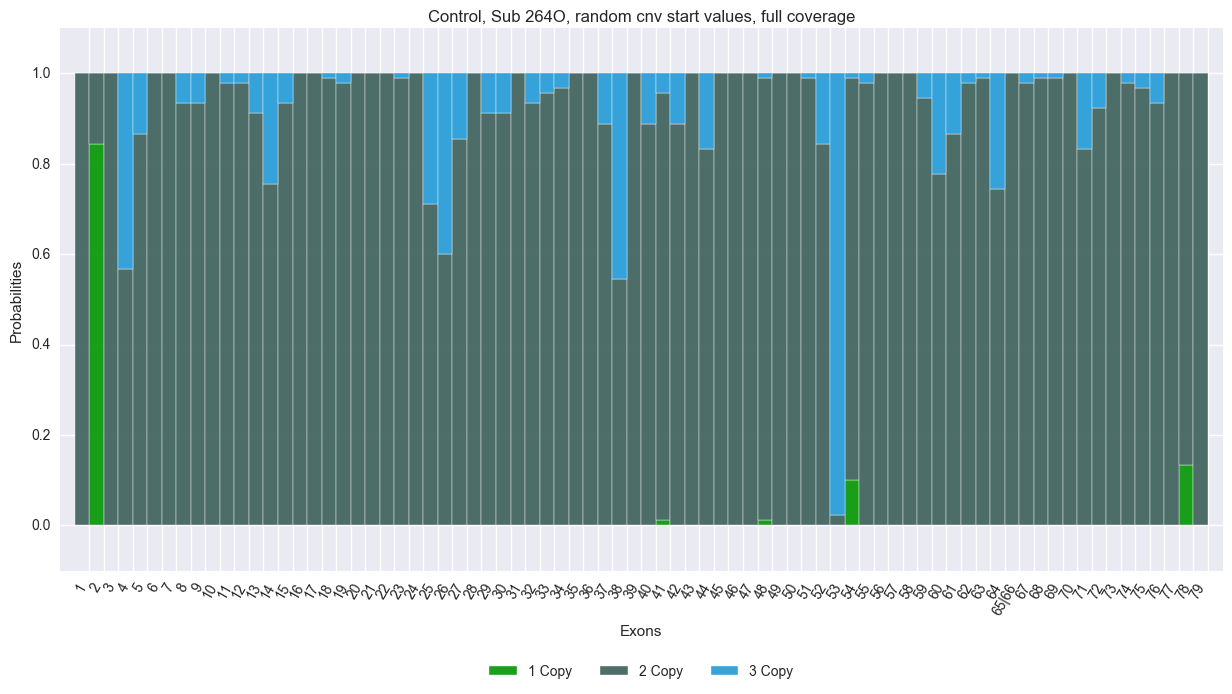

In [429]:
create_stacked_bars(mh_df_264O, 'Control, Sub 264O, random cnv start values, full coverage')

(<matplotlib.text.Text at 0x116ad7d90>, <matplotlib.text.Text at 0x11377c850>)

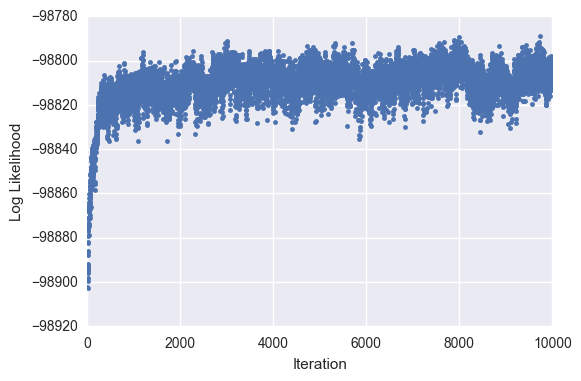

In [343]:
plt.figure()
plt.plot(range(len(mh_logliks_264O)), mh_logliks_264O, '.')
plt.xlabel('Iteration'), plt.ylabel('Log Likelihood')

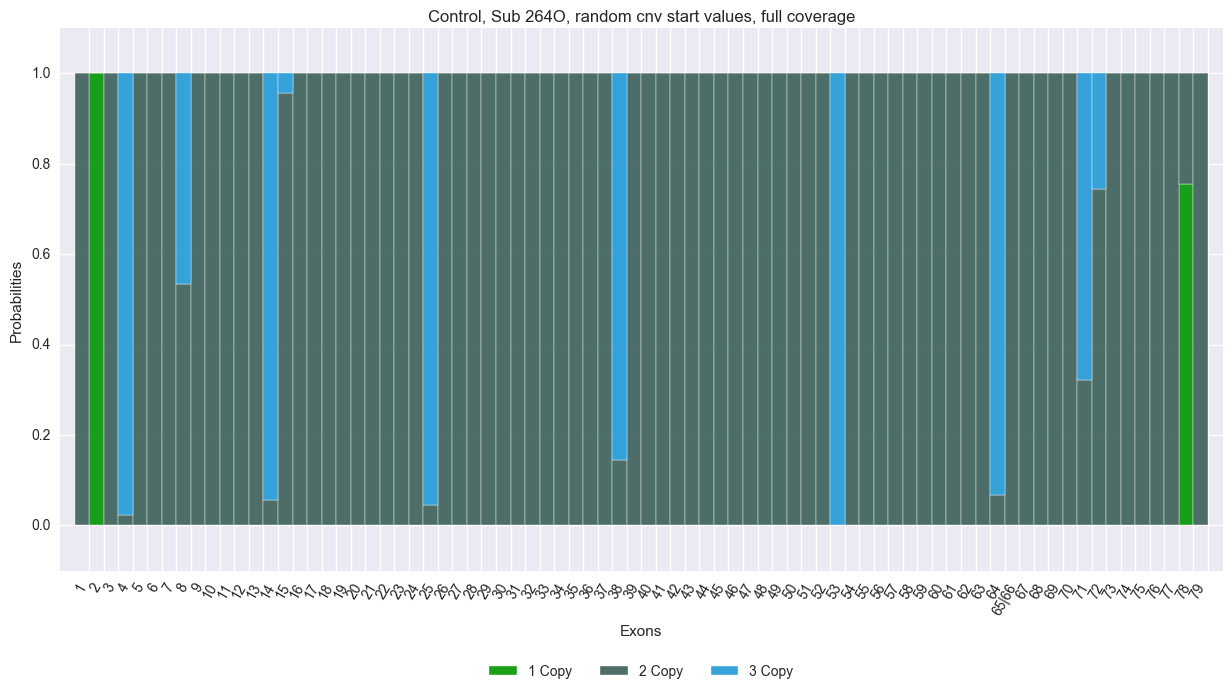

In [340]:
create_stacked_bars(gibbs_df_264O, 'Control, Sub 264O, random cnv start values, full coverage')

## Simulated subjects

In [806]:
# with random cnv distribution
cnv_support = [1,2,3]
gibbs_data_822Rc, gibbsX_822Rc, gibbs_data_results_822Rc, logliks_822Rc, gibbs_df_822Rc = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['822R'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 1 3 1 1 2 3 2 1 1 1 3 1 2 1 2 3 3 3 1 2 2 2 2 1 1 1 3 3 2 1 2 2 2 2 1 2
 2 1 1 3 3 1 3 1 1 2 1 1 1 1 3 1 3 2 1 3 2 3 3 2 2 3 1 3 2 2 1 3 3 3 2 3 3
 1 3 2 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


In [430]:
%%time
# with random cnv distribution
cnv_support = [1,2,3]
mh_data_822Rc, mh_822Rc, mh_data_results_822Rc, mhlogliks_822Rc, mh_df_822Rc = metro_hastings(cnv_support, 
                                                                        mu_sub, cov_sub, data=data_dict['822R'], 
                                                                        iterations=10000, exon_labels=exon_labels,
                                                                        use_diag_approx=True)

[3 2 3 2 2 1 2 1 1 2 3 3 2 2 1 2 1 1 2 3 1 3 3 3 3 3 1 3 2 1 3 3 2 2 3 1 3
 3 1 1 1 2 2 2 2 2 2 1 2 2 1 3 1 1 1 2 2 2 1 2 2 3 1 2 3 3 1 1 1 1 2 1 2 1
 1 2 3 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
Acceptance ratio: 0.111551282051
CPU times: user 1min 8s, sys: 361 ms, total: 1min 9s
Wall time: 1min 9s


In [306]:
%%time
# with random cnv distribution
cnv_support = [1,2,3]
gibbs_data_822R, gibbsX_822R, gibbs_data_results_822R, logliks_822R, gibbs_df_822R = generate_gibbs_df(cnv_support, 
                                                                        mu_sub, cov_sub, data=data_dict['822R_del'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[2 3 1 3 2 3 1 1 2 1 2 3 1 1 3 3 2 3 2 3 2 2 3 3 1 2 2 2 2 1 2 3 2 3 1 3 2
 1 1 1 2 3 2 3 3 2 3 3 1 3 1 1 2 3 2 3 2 1 3 1 3 1 2 1 1 3 3 2 2 1 3 2 1 3
 3 3 3 2]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
Acceptance ratio: 0.0005
CPU times: user 1min 15s, sys: 2.63 s, total: 1min 18s
Wall time: 1min 16s


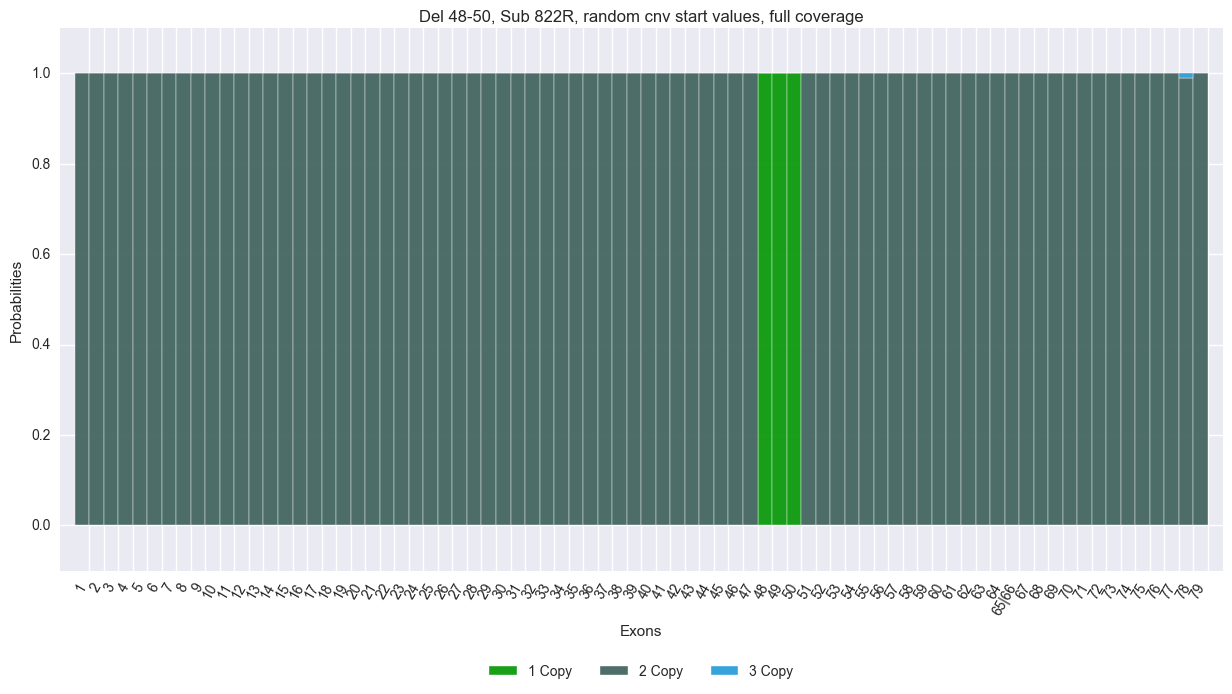

In [307]:
create_stacked_bars(gibbs_df_822R, 'Del 48-50, Sub 822R, random cnv start values, full coverage')

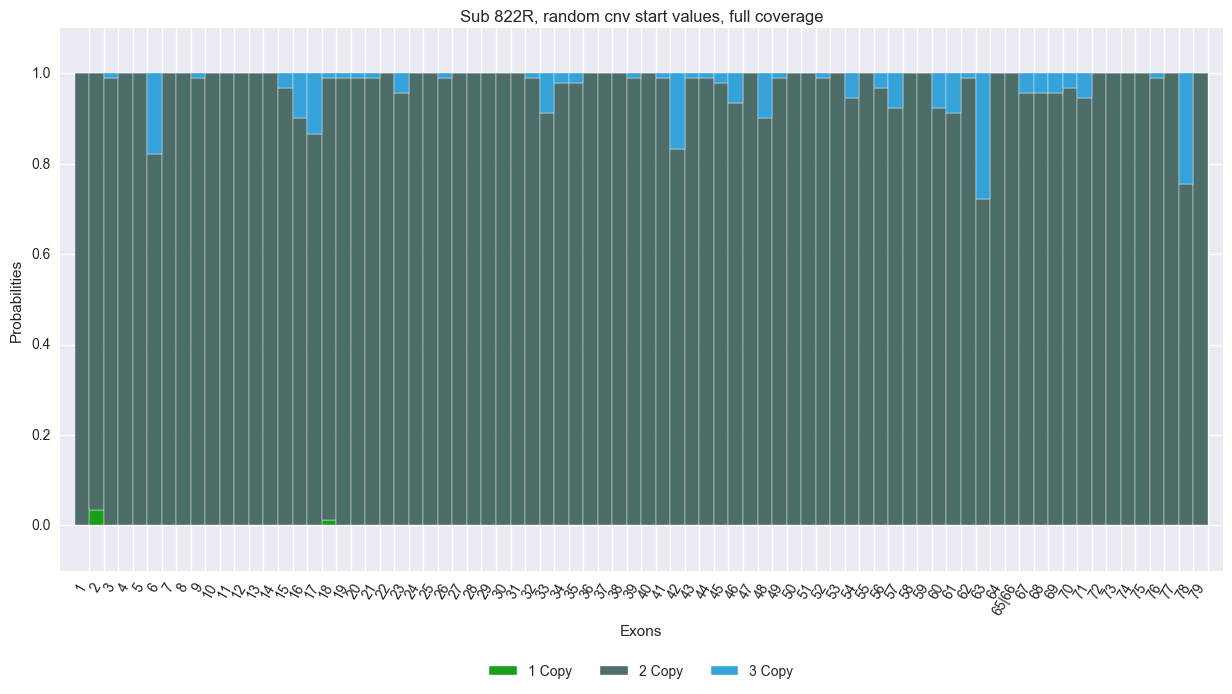

In [431]:
create_stacked_bars(mh_df_822Rc, 'Sub 822R, random cnv start values, full coverage')

(<matplotlib.text.Text at 0x116a6af10>, <matplotlib.text.Text at 0x11100c910>)

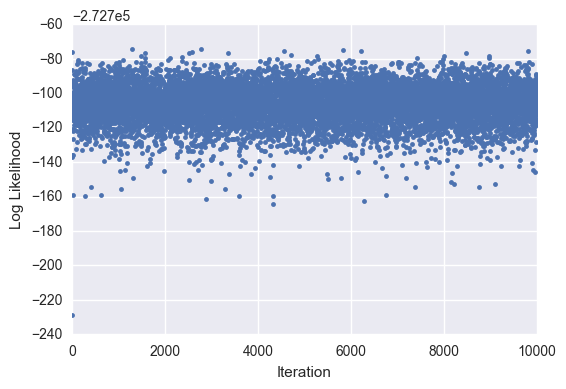

In [651]:
plt.figure()
plt.plot(range(len(logliks_822R2)), logliks_822R2, '.')
plt.xlabel('Iteration'), plt.ylabel('Log Likelihood')

In [667]:
# this subject's mutation was simulated with a 0.65 mult factor (instead of 0.5) so I'm correcting for it here
data_dict['J0F1_del'][15:19] = (data_dict['J0F1_del'][15:19]) * (0.5 / 0.65)

In [813]:
%%time
cnv_support = [1,2,3]
gibbs_data_J0F1, gibbsX_J0F1, gibbs_data_results_J0F1, logliks_J0F1, gibbs_df_J0F1 = generate_gibbs_df(cnv_support, 
                                                                        X_probs43, data=data_dict['J0F1_del'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 1 3 1 3 1 1 1 1 3 1 3 1 3 1 3 1 3 2 3 1 3 2 2 2 1 1 2 3 3 1 3 2 3 2 3 1
 3 1 1 3 1 2 1 2 2 3 1 3 2 1 1 3 2 1 2 2 1 3 3 1 2 1 1 1 1 2 2 2 1 1 2 2 1
 3 3 3 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
CPU times: user 56.7 s, sys: 324 ms, total: 57 s
Wall time: 57.6 s


In [814]:
cnv_support = [1,2,3]
gibbs_data_J0F1c, gibbsX_J0F1c, gibbs_data_results_J0F1c, logliks_J0F1c, gibbs_df_J0F1c = generate_gibbs_df(cnv_support, 
                                                                        X_probs43, data=data_dict['J0F1'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[3 3 3 3 3 1 1 2 3 3 3 1 2 1 3 3 1 1 3 3 3 2 3 2 3 1 3 3 2 1 3 3 1 3 1 1 1
 1 2 1 2 1 1 1 3 2 2 3 2 1 2 2 3 3 1 1 3 1 2 3 3 1 1 2 1 3 1 1 1 2 2 2 2 3
 2 2 1 3]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


In [436]:
cnv_support = [1,2,3]
cnv_start = 2.0 * np.ones(78)
mh_data_J0F1c, mhX_J0F1c, mh_data_results_J0F1c, mhlogliks_J0F1c, mh_df_J0F1c = metro_hastings(cnv_support, 
                                                                        mu_sub, cov_sub, cnv=cnv_start, data=data_dict['J0F1'], 
                                                                        iterations=10000, exon_labels=exon_labels,
                                                                        use_diag_approx=True)

[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
Acceptance ratio: 0.138419230769


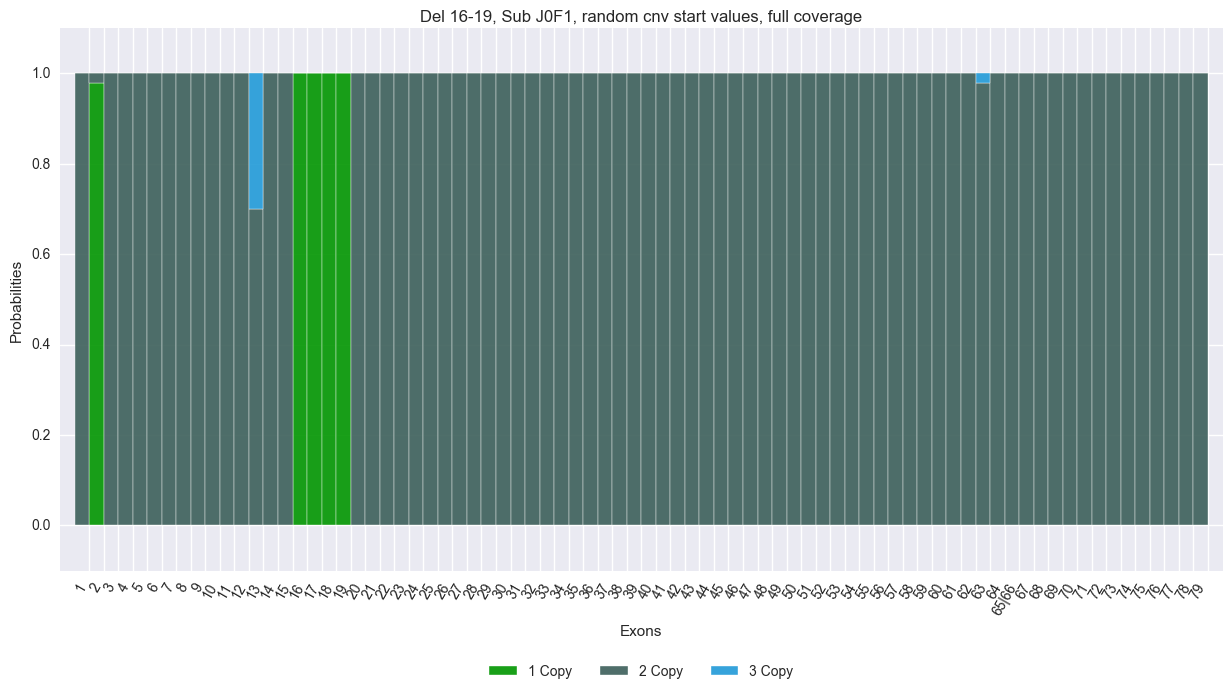

In [815]:
create_stacked_bars(gibbs_df_J0F1, 'Del 16-19, Sub J0F1, random cnv start values, full coverage')

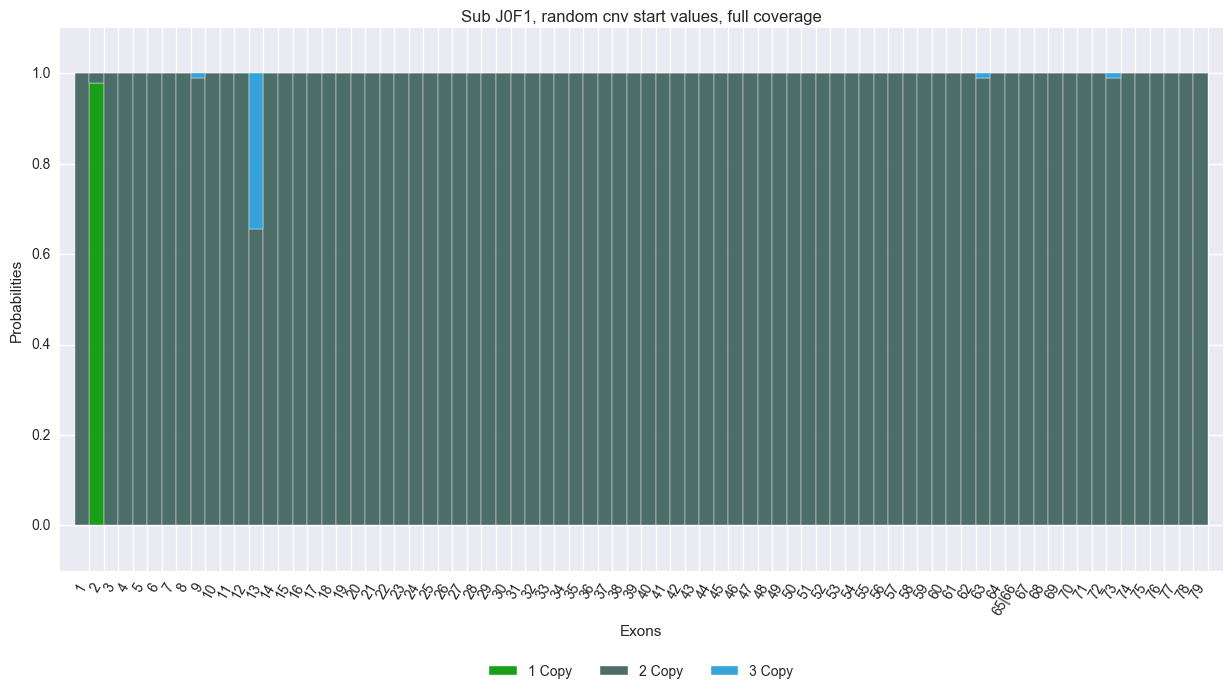

In [816]:
create_stacked_bars(gibbs_df_J0F1c, 'Sub J0F1, random cnv start values, full coverage')

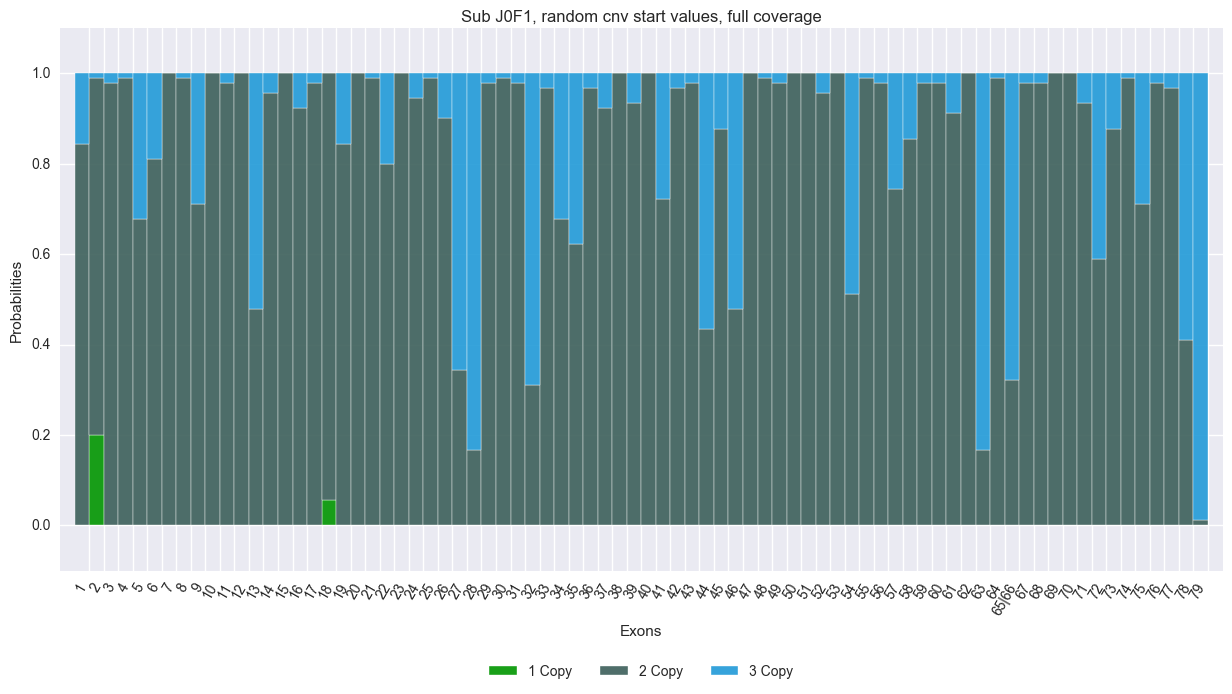

In [437]:
create_stacked_bars(mh_df_J0F1c, 'Sub J0F1, random cnv start values, full coverage')

In [786]:
cnv_support = [1,2,3]
gibbs_data_444F, gibbsX_444F, gibbs_data_results_444F, logliks_444F, gibbs_df_444F = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['444F_dup'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[1 1 1 1 3 3 3 3 3 3 1 2 2 2 1 3 2 2 2 2 2 1 3 3 3 2 1 3 3 1 3 2 2 1 1 1 1
 3 2 3 3 3 1 3 3 3 2 1 3 1 1 3 1 2 1 1 2 1 1 3 1 3 3 3 2 2 3 3 1 2 2 2 2 1
 3 2 2 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True


In [787]:
cnv_support = [1,2,3]
gibbs_data_444Fc, gibbsX_444Fc, gibbs_data_results_444Fc, logliks_444Fc, gibbs_df_444Fc = generate_gibbs_df(cnv_support, 
                                                                        X_probs38, data=data_dict['444F'], 
                                                                        iterations=10000, exon_labels=exon_labels)

[2 3 3 3 3 2 1 3 2 1 1 3 2 2 1 2 3 3 3 3 3 1 1 1 3 1 2 1 2 3 3 3 2 1 1 2 2
 2 1 1 2 1 1 2 1 3 1 1 2 1 3 1 1 2 2 1 3 1 1 2 3 2 3 2 1 2 1 3 1 3 2 3 2 3
 1 1 1 1]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations
780000
True


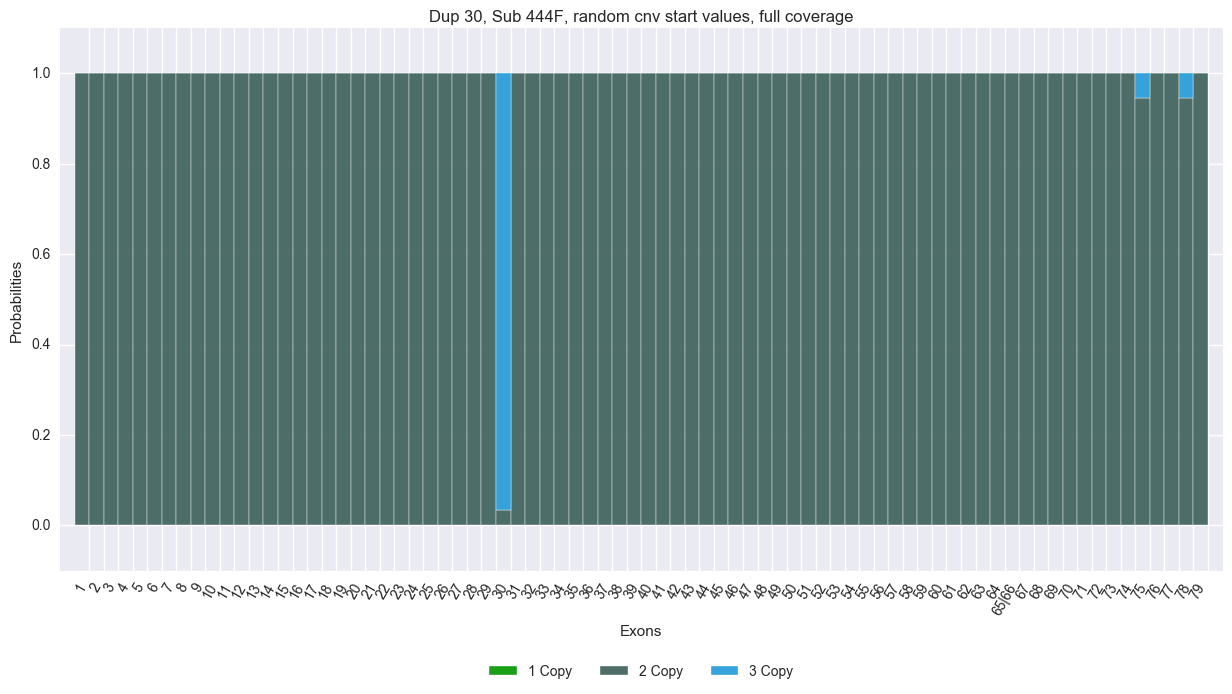

In [788]:
create_stacked_bars(gibbs_df_444F, 'Dup 30, Sub 444F, random cnv start values, full coverage')

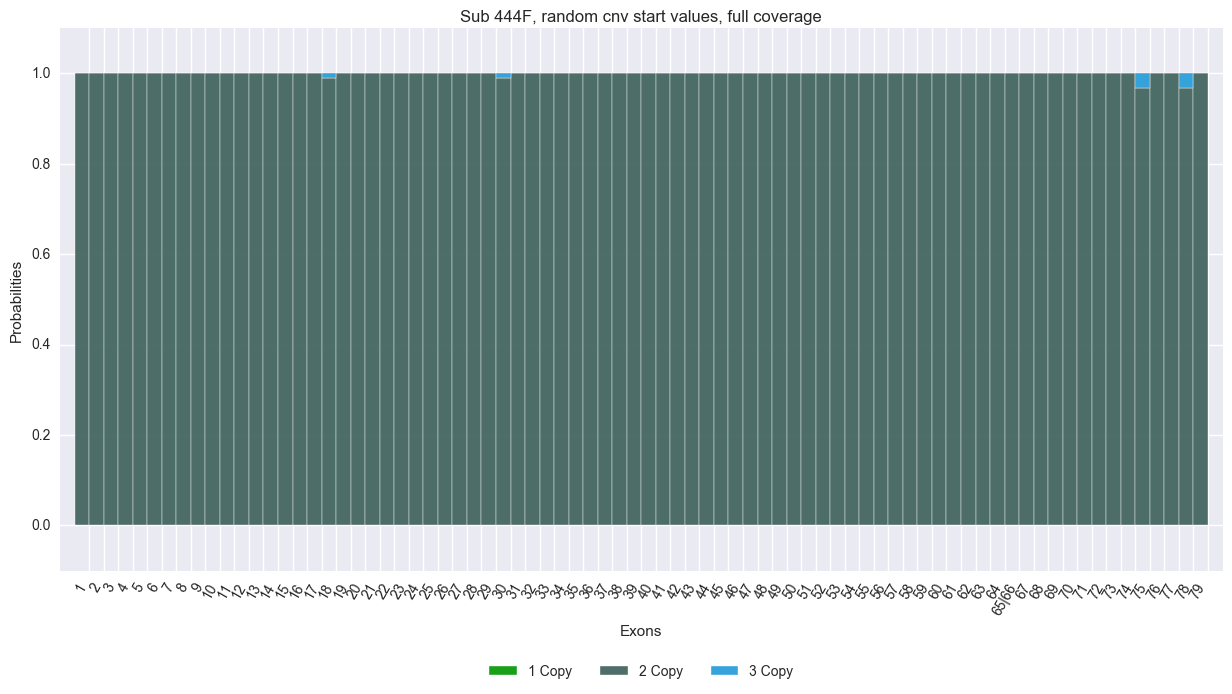

In [789]:
create_stacked_bars(gibbs_df_444Fc, 'Sub 444F, random cnv start values, full coverage')

This subject (and any simulated mutations based on her) will probably be excluded from future tests because her bams are actually merged files from the results of sequencing with at least two different mixin panels. This might explain the abnormal exon coverage ratios for at least some exons.

In [273]:
estimate_prop_full = (test_norm_rel.TSID_only - regression_full.params[0]) / regression_full.params[1]
estimate_prop_full

subject
FGPC-0000-444F        0.349709
FGPC-0000-444F_dup    0.349709
FGPC-4ZPF-J0F1        0.404720
FGPC-4ZPF-J0F1_del    0.404720
FPWB-0000-822R        0.351999
FPWB-0000-822R_del    0.351999
Name: TSID_only, dtype: float64